Website link: https://annikaljy.github.io/02467/

Done by Group 6: Annika Law Jie Yu, Byun Jane, Heo Jiwon

Github repo: https://github.com/annikaljy/02467

# Explainer Notebook

## Motivation

Music has always been a huge part of culture for thousands of years, and is undeniably a huge part of most peoples' lives today. As such, our group aims to explore how music genres influence each other through artist collaborations and shared features. By analyzing networks of artists linked by genres or co-listening patterns, we will achieve:

1. Identify any emerging genres through community detection
2. Understand cultural evolution by mapping how artists and genres interact with each other

We will be using the Music Genre dataset from zenodo, who uses data from Spotify. It is accessible through this link: https://zenodo.org/records/4778563

This dataset contains the following:
1. Genre networks
2. Genre mappings
3. Artist networks
4. Artists
5. Hit songs
6. Spotify Charts - Weekly Top 200 Charts

In particular, we chose this dataset as we wanted to work with data from Spotify - who is the biggest music streaming platform in the world currently. However, due to Spotify's strict api limit, we are unable to achieve the required data efficiently. As such, we decided to utilise zenodo's dataset instead, who uses data from Spotify as well.

Our end goal is to provide an interactive webpage for users who are interested to explore artist and genre connections, as well as highlight how the different genres would blend together. 

We aim to present our findings by using a variety of data visualisations and interactive network graphs. The webpage is designed so that the users would not have to read through any technical aspects of the code and make it easy for them to understand our results. We hope that our interactive features would make learning about genre diffusions more fun and appealing as well.

## Basic stats. Let's understand the dataset better

For data cleaning and preprocessing, we have decided to first and foremost avoid any parsing errors due to hidden characters, by performing str.strip(). We also decided to drop rows with any missing value and forces edge weights counts to be numeric by replacing invalid values -> NaN -> 1 to default any corrupted/missing counts.

We will be mainly working on 'artist_networks.zip' and 'artist_data.zip' for our analysis. 

To start off, we will be analysing artist_networks (global) which is a dataset of networks of collaborating artists whose songs appeared on the Top 200 Chart on Spotify. It is separated into 3 different years - 2017, 2018 and 2019. There are 680 collaborations in 2017, 927 collaborations in 2018 and 1067 collaborations in 2019.

For the artist_data, we will be using spotify_artists_info_complete.csv which is the artists who made hit songs according to Spotify Top 200 charts in 2017-2019. There are 3612 rows of data in this dataset.

# Artist Collaboration Network Analysis (2017~2019)

Firstly, we will visualise the network of artist collaborations. Although this section does not invovle text processing, it handles text data in artist names.

We have used NetworkX to construct the graph, louvain algorithm to detect communities and matplotlib for the visualisation. A combination of these 3 tools help us identify communities and the degrees of the nodes (artists) and provide a visual representation.

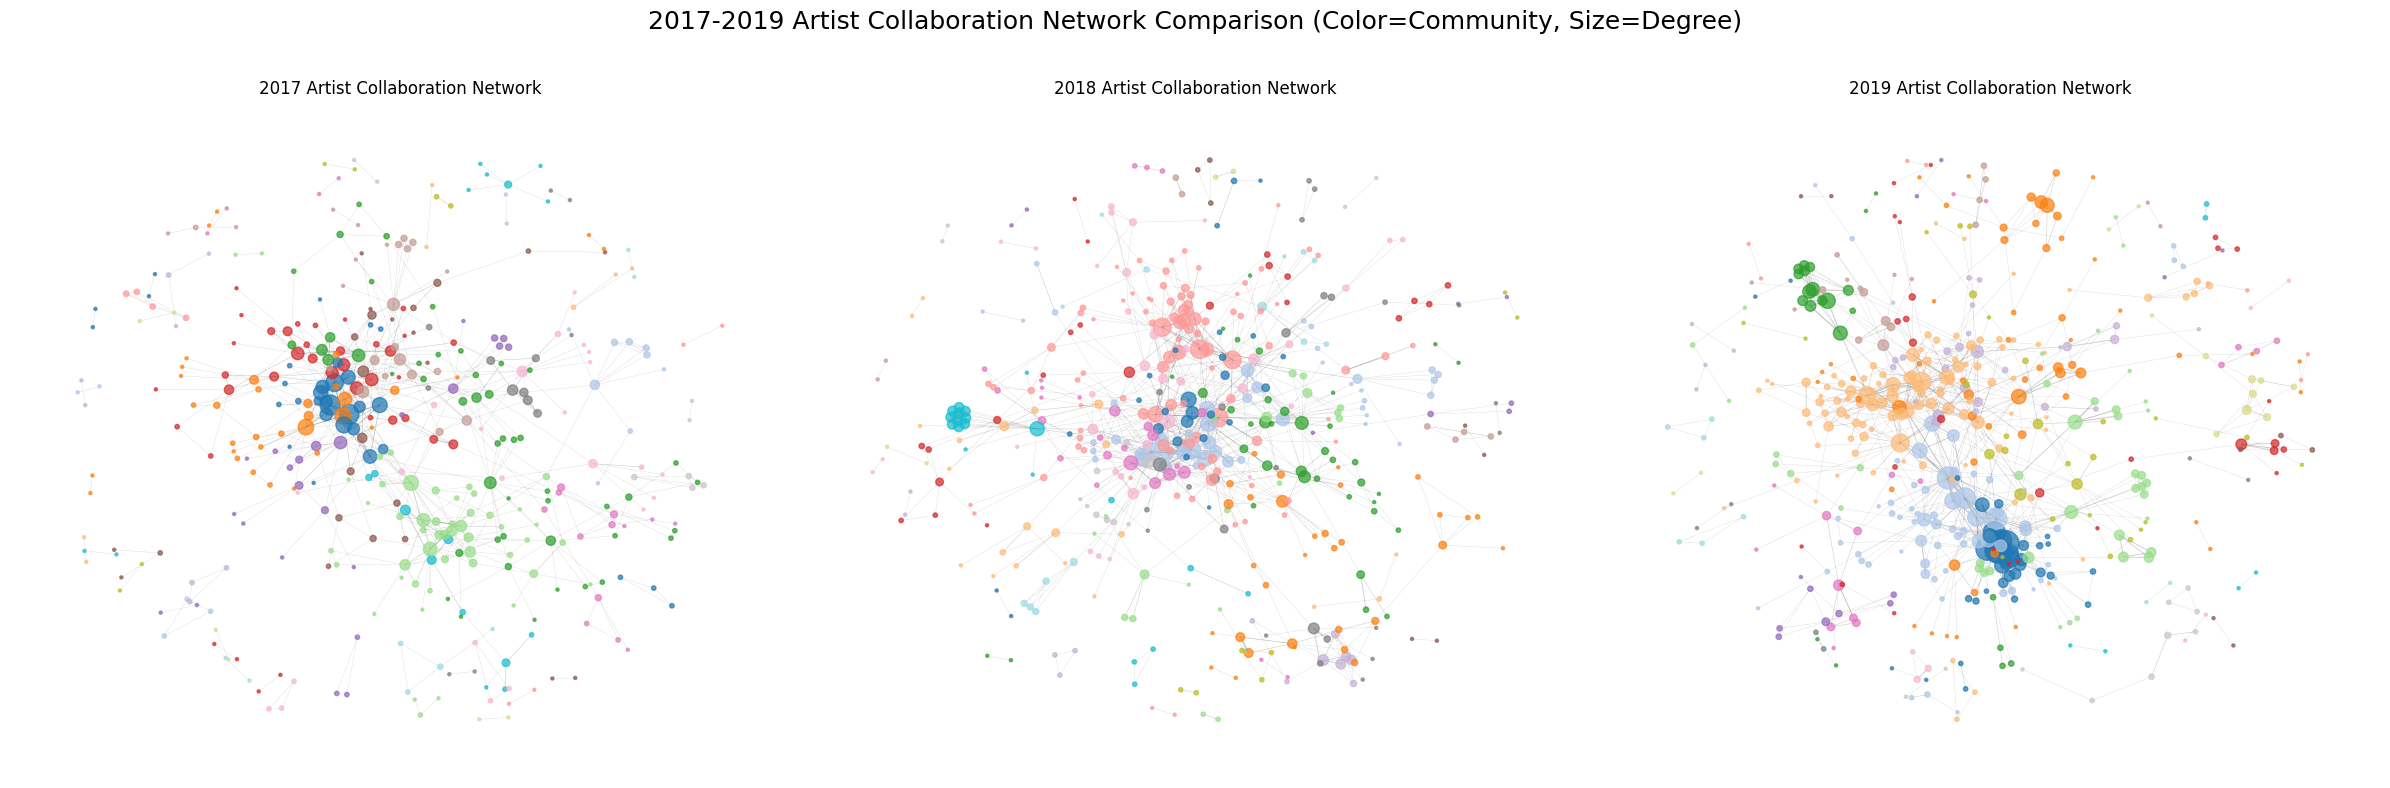

In [1]:

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import community as community_louvain
import numpy as np

files = {
    2017: '/content/global-artist_network-2017.csv',
    2018: '/content/global-artist_network-2018.csv',
    2019: '/content/global-artist_network-2019.csv'
}

graphs = {}
partitions = {}
degrees = {}

for year, path in files.items():
    try:
        df = pd.read_csv(path, sep='\t', engine='python')
        edge_cols = ['artist_1', 'artist_2', 'count']
    except Exception:
        df = pd.read_csv(path, sep='\s+', engine='python')
        edge_cols = ['artist1', 'artist2', 'count']
    df.columns = df.columns.str.strip()
    edges = df[edge_cols].dropna()
    edges['count'] = pd.to_numeric(edges['count'], errors='coerce').fillna(1).astype(int)

    G = nx.Graph()
    for _, row in edges.iterrows():
        G.add_edge(row[edge_cols[0]], row[edge_cols[1]], weight=row['count'])

    partition = community_louvain.best_partition(G, weight='weight')
    deg = dict(G.degree(weight='weight'))
    graphs[year] = G
    partitions[year] = partition
    degrees[year] = deg


fig, axes = plt.subplots(1, 3, figsize=(24, 8))
cmap = plt.get_cmap('tab20')

for idx, year in enumerate(sorted(files.keys())):
    G = graphs[year]
    partition = partitions[year]
    deg = degrees[year]
    communities = [partition[n] for n in G.nodes()]
    colors = [cmap(c % 20) for c in communities]
    node_sizes = [deg[n]*5 for n in G.nodes()]

    pos = nx.spring_layout(G, k=0.15, seed=42)
    ax = axes[idx]
    nx.draw_networkx_nodes(G, pos, node_color=colors, node_size=node_sizes, alpha=0.7, ax=ax)
    nx.draw_networkx_edges(G, pos, width=[G[u][v]['weight']*0.2 for u, v in G.edges()], alpha=0.2, ax=ax)
    ax.set_title(f'{year} Artist Collaboration Network')
    ax.axis('off')

plt.suptitle('2017-2019 Artist Collaboration Network Comparison (Color=Community, Size=Degree)', fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


<ipython-input-2-bd41f31aa4a9>:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .groupby('community').apply(lambda x: x.nlargest(N, 'degree')).reset_index(drop=True)


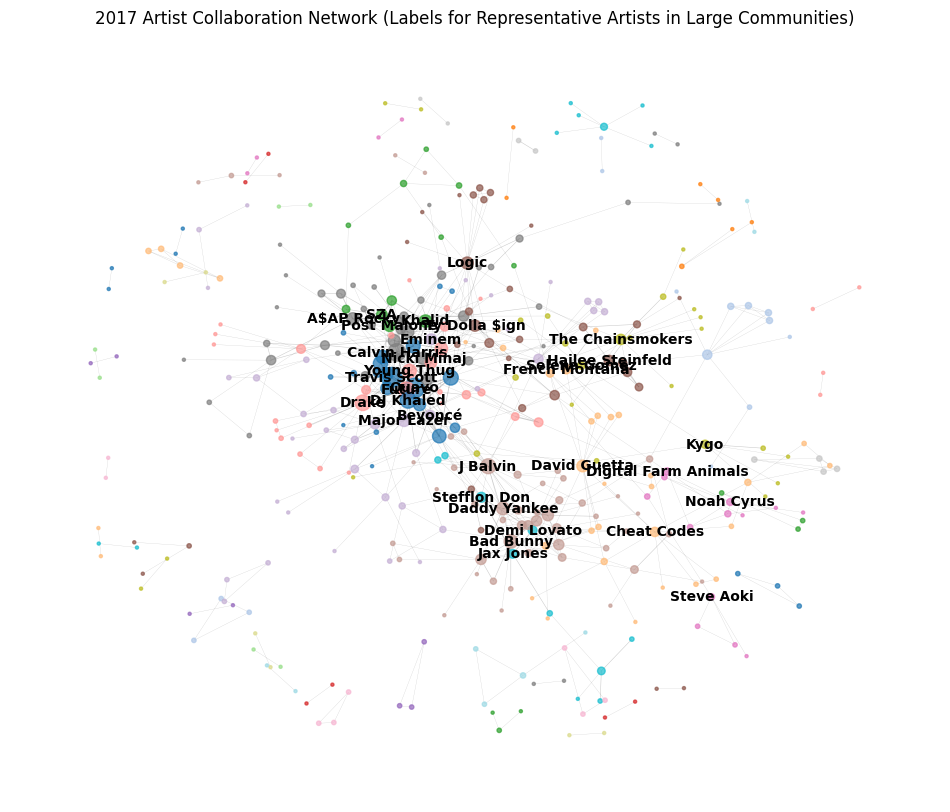

In [2]:

df = pd.read_csv('/content/global-artist_network-2017.csv', sep='\t', engine='python', quoting=3)
df.columns = df.columns.str.strip()
edges = df[['artist_1', 'artist_2', 'count']].dropna()
edges['count'] = pd.to_numeric(edges['count'], errors='coerce').fillna(1).astype(int)

G = nx.Graph()
for _, row in edges.iterrows():
    G.add_edge(row['artist_1'], row['artist_2'], weight=row['count'])

partition = community_louvain.best_partition(G, weight='weight')
nx.set_node_attributes(G, partition, 'community')
degrees = dict(G.degree(weight='weight'))

nodes_data = []
for node in G.nodes():
    deg = degrees.get(node, 0)
    comm = partition.get(node, -1)
    nodes_data.append({'artist': node, 'degree': deg, 'community': comm})
nodes_df = pd.DataFrame(nodes_data)

community_sizes = nodes_df.groupby('community').size()

min_community_size = 10
large_communities = community_sizes[community_sizes >= min_community_size].index

N = 3
rep_artist_df = nodes_df[nodes_df['community'].isin(large_communities)] \
    .groupby('community').apply(lambda x: x.nlargest(N, 'degree')).reset_index(drop=True)
rep_artist_set = set(rep_artist_df['artist'])


def escape_label(label):
    return re.sub(r'([$\\_^\{\}#&%~])', r'\\\1', str(label))

cmap = plt.get_cmap('tab20')
communities = [partition[n] for n in G.nodes()]
colors = [cmap(c % 20) for c in communities]
node_sizes = [degrees[n]*5 for n in G.nodes()]
pos = nx.spring_layout(G, k=0.15, seed=42)

plt.figure(figsize=(12, 10))
nx.draw_networkx_nodes(G, pos, node_color=colors, node_size=node_sizes, alpha=0.7)
nx.draw_networkx_edges(G, pos, width=[G[u][v]['weight']*0.2 for u, v in G.edges()], alpha=0.2)

label_dict = {n: escape_label(n) for n in G.nodes() if n in rep_artist_set}
nx.draw_networkx_labels(G, pos, labels=label_dict, font_size=10, font_weight='bold')
plt.title('2017 Artist Collaboration Network (Labels for Representative Artists in Large Communities)')
plt.axis('off')
plt.show()


<ipython-input-3-fd67086afd18>:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .groupby('community').apply(lambda x: x.nlargest(N, 'degree')).reset_index(drop=True)


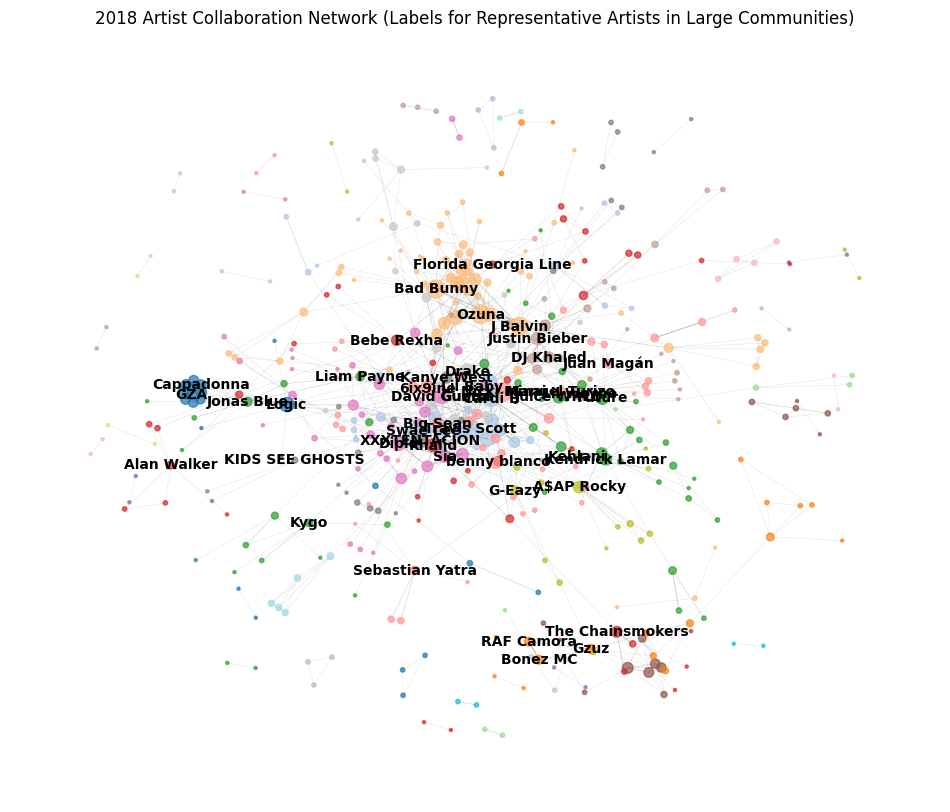

In [3]:
#2018
df = pd.read_csv('/content/global-artist_network-2018.csv', sep='\t', engine='python', quoting=3)
df.columns = df.columns.str.strip()
edges = df[['artist_1', 'artist_2', 'count']].dropna()
edges['count'] = pd.to_numeric(edges['count'], errors='coerce').fillna(1).astype(int)

G = nx.Graph()
for _, row in edges.iterrows():
    G.add_edge(row['artist_1'], row['artist_2'], weight=row['count'])

partition = community_louvain.best_partition(G, weight='weight')
nx.set_node_attributes(G, partition, 'community')
degrees = dict(G.degree(weight='weight'))

nodes_data = []
for node in G.nodes():
    deg = degrees.get(node, 0)
    comm = partition.get(node, -1)
    nodes_data.append({'artist': node, 'degree': deg, 'community': comm})
nodes_df = pd.DataFrame(nodes_data)


community_sizes = nodes_df.groupby('community').size()

min_community_size = 10
large_communities = community_sizes[community_sizes >= min_community_size].index

N = 3
rep_artist_df = nodes_df[nodes_df['community'].isin(large_communities)] \
    .groupby('community').apply(lambda x: x.nlargest(N, 'degree')).reset_index(drop=True)
rep_artist_set = set(rep_artist_df['artist'])

def escape_label(label):
    return re.sub(r'([$\\_^\{\}#&%~])', r'\\\1', str(label))


cmap = plt.get_cmap('tab20')
communities = [partition[n] for n in G.nodes()]
colors = [cmap(c % 20) for c in communities]
node_sizes = [degrees[n]*5 for n in G.nodes()]
pos = nx.spring_layout(G, k=0.15, seed=42)

plt.figure(figsize=(12, 10))
nx.draw_networkx_nodes(G, pos, node_color=colors, node_size=node_sizes, alpha=0.7)
nx.draw_networkx_edges(G, pos, width=[G[u][v]['weight']*0.2 for u, v in G.edges()], alpha=0.2)

label_dict = {n: escape_label(n) for n in G.nodes() if n in rep_artist_set}
nx.draw_networkx_labels(G, pos, labels=label_dict, font_size=10, font_weight='bold')
plt.title('2018 Artist Collaboration Network (Labels for Representative Artists in Large Communities)')
plt.axis('off')
plt.show()


<ipython-input-4-b97535b5cebd>:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .groupby('community').apply(lambda x: x.nlargest(N, 'degree')).reset_index(drop=True)


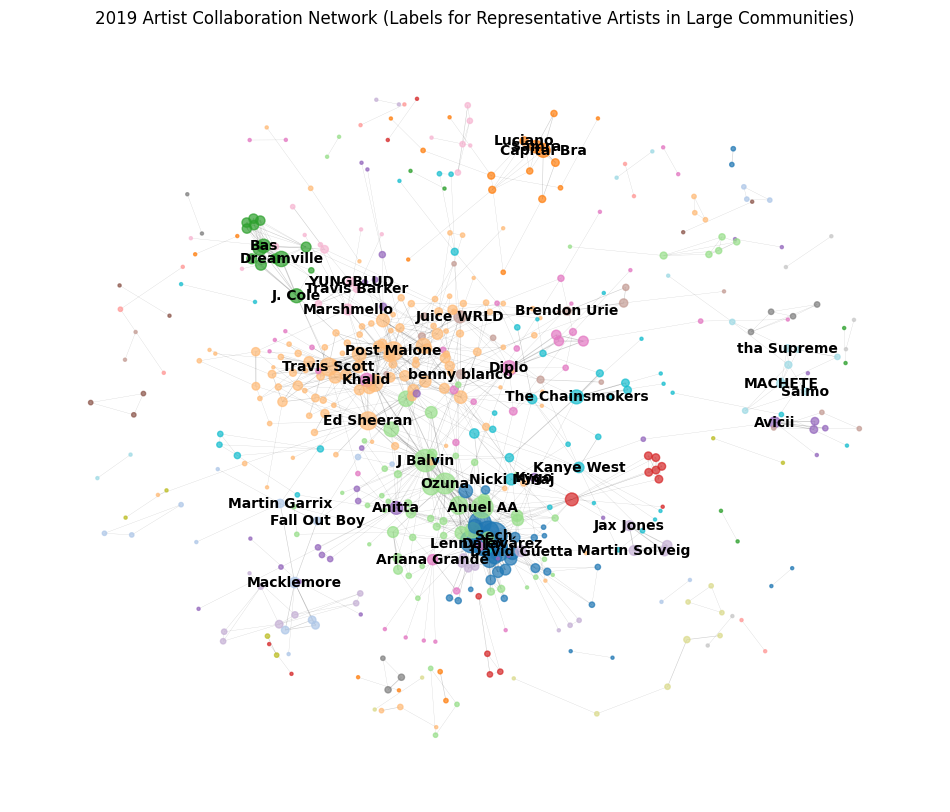

In [4]:
#2019
df = pd.read_csv('/content/global-artist_network-2019.csv', sep='\t', engine='python', quoting=3)
df.columns = df.columns.str.strip()
edges = df[['artist_1', 'artist_2', 'count']].dropna()
edges['count'] = pd.to_numeric(edges['count'], errors='coerce').fillna(1).astype(int)

G = nx.Graph()
for _, row in edges.iterrows():
    G.add_edge(row['artist_1'], row['artist_2'], weight=row['count'])

partition = community_louvain.best_partition(G, weight='weight')
nx.set_node_attributes(G, partition, 'community')
degrees = dict(G.degree(weight='weight'))

nodes_data = []
for node in G.nodes():
    deg = degrees.get(node, 0)
    comm = partition.get(node, -1)
    nodes_data.append({'artist': node, 'degree': deg, 'community': comm})
nodes_df = pd.DataFrame(nodes_data)

community_sizes = nodes_df.groupby('community').size()

min_community_size = 10
large_communities = community_sizes[community_sizes >= min_community_size].index

N = 3
rep_artist_df = nodes_df[nodes_df['community'].isin(large_communities)] \
    .groupby('community').apply(lambda x: x.nlargest(N, 'degree')).reset_index(drop=True)
rep_artist_set = set(rep_artist_df['artist'])

def escape_label(label):
    return re.sub(r'([$\\_^\{\}#&%~])', r'\\\1', str(label))

cmap = plt.get_cmap('tab20')
communities = [partition[n] for n in G.nodes()]
colors = [cmap(c % 20) for c in communities]
node_sizes = [degrees[n]*5 for n in G.nodes()]
pos = nx.spring_layout(G, k=0.15, seed=42)

plt.figure(figsize=(12, 10))
nx.draw_networkx_nodes(G, pos, node_color=colors, node_size=node_sizes, alpha=0.7)
nx.draw_networkx_edges(G, pos, width=[G[u][v]['weight']*0.2 for u, v in G.edges()], alpha=0.2)

label_dict = {n: escape_label(n) for n in G.nodes() if n in rep_artist_set}
nx.draw_networkx_labels(G, pos, labels=label_dict, font_size=10, font_weight='bold')
plt.title('2019 Artist Collaboration Network (Labels for Representative Artists in Large Communities)')
plt.axis('off')
plt.show()


## Visualization of Core Artist Network


We will now analyse the core artist network by choosing the artist with the highest degree in each community, then creating a graph for it.

We will once again be using the same 3 tools as mentioned in the previous analysis.

<ipython-input-5-9f38a59a10fd>:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rep_artist_df = nodes_df.groupby('community').apply(lambda x: x.nlargest(1, 'degree')).reset_index(drop=True)


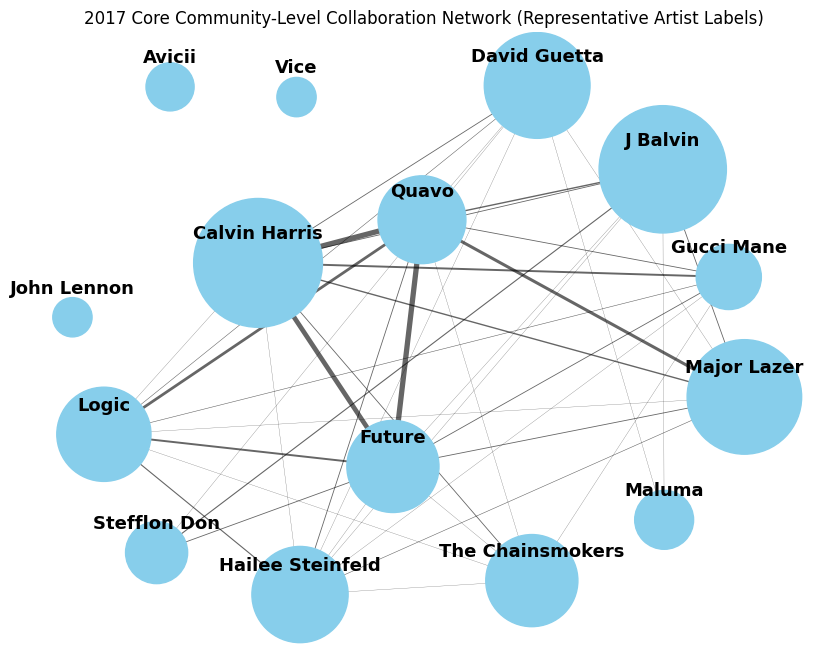

In [5]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import community as community_louvain
import re
import numpy as np

df = pd.read_csv('global-artist_network-2017.csv', sep='\t', engine='python', quoting=3)
df.columns = df.columns.str.strip()
edges = df[['artist_1', 'artist_2', 'count']].dropna()
edges['count'] = pd.to_numeric(edges['count'], errors='coerce').fillna(1).astype(int)

G = nx.Graph()
for _, row in edges.iterrows():
    G.add_edge(row['artist_1'], row['artist_2'], weight=row['count'])

partition = community_louvain.best_partition(G, weight='weight')
nx.set_node_attributes(G, partition, 'community')
degrees = dict(G.degree(weight='weight'))

nodes_data = []
for node in G.nodes():
    deg = degrees.get(node, 0)
    comm = partition.get(node, -1)
    nodes_data.append({'artist': node, 'degree': deg, 'community': comm})
nodes_df = pd.DataFrame(nodes_data)

rep_artist_df = nodes_df.groupby('community').apply(lambda x: x.nlargest(1, 'degree')).reset_index(drop=True)
rep_artist_names = rep_artist_df.set_index('community')['artist'].to_dict()

community_graph = nx.Graph()
for comm in nodes_df['community'].unique():
    community_graph.add_node(comm)

for u, v, data in G.edges(data=True):
    comm_u = partition[u]
    comm_v = partition[v]
    if comm_u != comm_v:
        key = tuple(sorted([comm_u, comm_v]))
        if community_graph.has_edge(*key):
            community_graph[key[0]][key[1]]['weight'] += data['weight']
        else:
            community_graph.add_edge(key[0], key[1], weight=data['weight'])

# only core communities (with the largest total edge weights)
community_degrees = {comm: len(nodes_df[nodes_df['community']==comm]) for comm in community_graph.nodes()}
top_communities = sorted(community_degrees, key=community_degrees.get, reverse=True)[:15]
subgraph = community_graph.subgraph(top_communities).copy()

def escape_label(label):
    return re.sub(r'([$\\_^\{\}#&%~])', r'\\\1', str(label))

sub_labels = {comm: escape_label(rep_artist_names.get(comm, str(comm))) for comm in subgraph.nodes()}
node_sizes = [community_degrees[comm]*200 for comm in subgraph.nodes()]
edge_widths = [subgraph[u][v]['weight']*0.2 for u,v in subgraph.edges()]

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(subgraph, seed=42, k=5)
nx.draw_networkx_nodes(subgraph, pos, node_color='skyblue', node_size=node_sizes)
nx.draw_networkx_edges(subgraph, pos, width=edge_widths, alpha=0.6)
for comm, (x, y) in pos.items():
    plt.text(x, y+0.07, sub_labels[comm], fontsize=13, fontweight='bold', ha='center', va='bottom')
plt.title('2017 Core Community-Level Collaboration Network (Representative Artist Labels)')
plt.axis('off')
plt.show()


<ipython-input-6-3f13580cd869>:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rep_artist_df = nodes_df.groupby('community').apply(lambda x: x.nlargest(1, 'degree')).reset_index(drop=True)


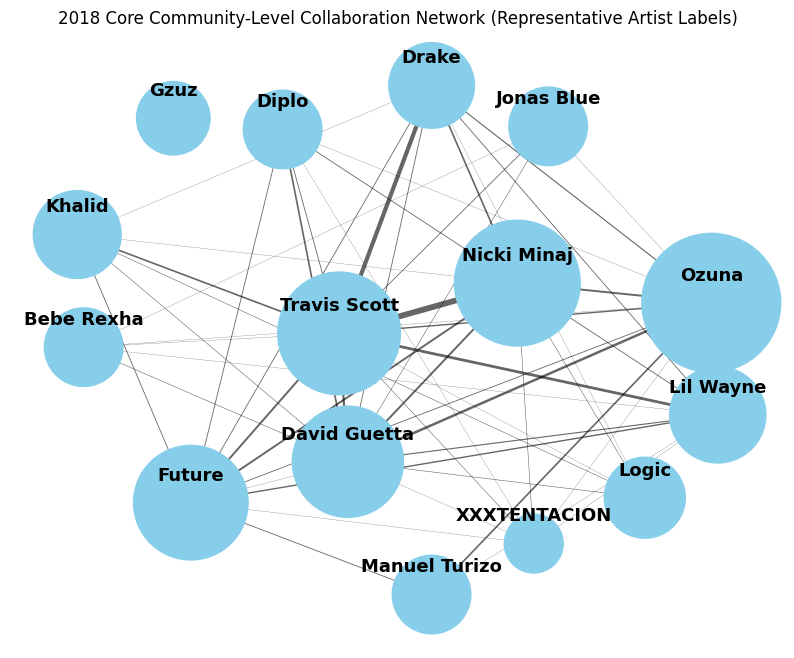

In [6]:

df = pd.read_csv('global-artist_network-2018.csv', sep='\t', engine='python', quoting=3)
df.columns = df.columns.str.strip()
edges = df[['artist_1', 'artist_2', 'count']].dropna()
edges['count'] = pd.to_numeric(edges['count'], errors='coerce').fillna(1).astype(int)

G = nx.Graph()
for _, row in edges.iterrows():
    G.add_edge(row['artist_1'], row['artist_2'], weight=row['count'])

partition = community_louvain.best_partition(G, weight='weight')
nx.set_node_attributes(G, partition, 'community')
degrees = dict(G.degree(weight='weight'))

nodes_data = []
for node in G.nodes():
    deg = degrees.get(node, 0)
    comm = partition.get(node, -1)
    nodes_data.append({'artist': node, 'degree': deg, 'community': comm})
nodes_df = pd.DataFrame(nodes_data)

rep_artist_df = nodes_df.groupby('community').apply(lambda x: x.nlargest(1, 'degree')).reset_index(drop=True)
rep_artist_names = rep_artist_df.set_index('community')['artist'].to_dict()

community_graph = nx.Graph()
for comm in nodes_df['community'].unique():
    community_graph.add_node(comm)

for u, v, data in G.edges(data=True):
    comm_u = partition[u]
    comm_v = partition[v]
    if comm_u != comm_v:
        key = tuple(sorted([comm_u, comm_v]))
        if community_graph.has_edge(*key):
            community_graph[key[0]][key[1]]['weight'] += data['weight']
        else:
            community_graph.add_edge(key[0], key[1], weight=data['weight'])

community_degrees = {comm: len(nodes_df[nodes_df['community']==comm]) for comm in community_graph.nodes()}
top_communities = sorted(community_degrees, key=community_degrees.get, reverse=True)[:15]
subgraph = community_graph.subgraph(top_communities).copy()

def escape_label(label):
    return re.sub(r'([$\\_^\{\}#&%~])', r'\\\1', str(label))

sub_labels = {comm: escape_label(rep_artist_names.get(comm, str(comm))) for comm in subgraph.nodes()}
node_sizes = [community_degrees[comm]*200 for comm in subgraph.nodes()]
edge_widths = [subgraph[u][v]['weight']*0.2 for u,v in subgraph.edges()]

plt.figure(figsize=(10, 8))

pos = nx.spring_layout(subgraph, seed=42, k=5)
nx.draw_networkx_nodes(subgraph, pos, node_color='skyblue', node_size=node_sizes)
nx.draw_networkx_edges(subgraph, pos, width=edge_widths, alpha=0.6)

for comm, (x, y) in pos.items():
    plt.text(x, y+0.07, sub_labels[comm], fontsize=13, fontweight='bold', ha='center', va='bottom')
plt.title('2018 Core Community-Level Collaboration Network (Representative Artist Labels)')
plt.axis('off')
plt.show()


<ipython-input-7-4f82f6c494f4>:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rep_artist_df = nodes_df.groupby('community').apply(lambda x: x.nlargest(1, 'degree')).reset_index(drop=True)


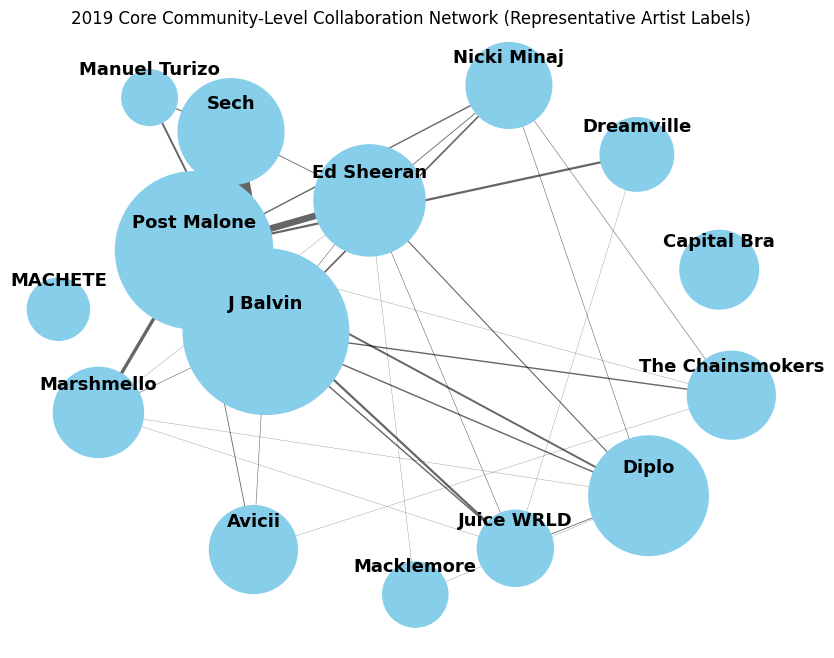

In [7]:

df = pd.read_csv('global-artist_network-2019.csv', sep='\t', engine='python', quoting=3)
df.columns = df.columns.str.strip()
edges = df[['artist_1', 'artist_2', 'count']].dropna()
edges['count'] = pd.to_numeric(edges['count'], errors='coerce').fillna(1).astype(int)

G = nx.Graph()
for _, row in edges.iterrows():
    G.add_edge(row['artist_1'], row['artist_2'], weight=row['count'])

partition = community_louvain.best_partition(G, weight='weight')
nx.set_node_attributes(G, partition, 'community')
degrees = dict(G.degree(weight='weight'))

nodes_data = []
for node in G.nodes():
    deg = degrees.get(node, 0)
    comm = partition.get(node, -1)
    nodes_data.append({'artist': node, 'degree': deg, 'community': comm})
nodes_df = pd.DataFrame(nodes_data)

rep_artist_df = nodes_df.groupby('community').apply(lambda x: x.nlargest(1, 'degree')).reset_index(drop=True)
rep_artist_names = rep_artist_df.set_index('community')['artist'].to_dict()

community_graph = nx.Graph()
for comm in nodes_df['community'].unique():
    community_graph.add_node(comm)

for u, v, data in G.edges(data=True):
    comm_u = partition[u]
    comm_v = partition[v]
    if comm_u != comm_v:
        key = tuple(sorted([comm_u, comm_v]))
        if community_graph.has_edge(*key):
            community_graph[key[0]][key[1]]['weight'] += data['weight']
        else:
            community_graph.add_edge(key[0], key[1], weight=data['weight'])


community_degrees = {comm: len(nodes_df[nodes_df['community']==comm]) for comm in community_graph.nodes()}
top_communities = sorted(community_degrees, key=community_degrees.get, reverse=True)[:15]
subgraph = community_graph.subgraph(top_communities).copy()

def escape_label(label):
    return re.sub(r'([$\\_^\{\}#&%~])', r'\\\1', str(label))

sub_labels = {comm: escape_label(rep_artist_names.get(comm, str(comm))) for comm in subgraph.nodes()}
node_sizes = [community_degrees[comm]*200 for comm in subgraph.nodes()]
edge_widths = [subgraph[u][v]['weight']*0.2 for u,v in subgraph.edges()]

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(subgraph, seed=42, k=5)
nx.draw_networkx_nodes(subgraph, pos, node_color='skyblue', node_size=node_sizes)
nx.draw_networkx_edges(subgraph, pos, width=edge_widths, alpha=0.6)

for comm, (x, y) in pos.items():
    plt.text(x, y+0.07, sub_labels[comm], fontsize=13, fontweight='bold', ha='center', va='bottom')
plt.title('2019 Core Community-Level Collaboration Network (Representative Artist Labels)')
plt.axis('off')
plt.show()


### Genre Distribution Aggregation for Top 15 Communities


In this section, we analyse the genre distribution for the top 15 communities. For each of the top artist (using data from the previous part), we will plot the top 10 genres for each of the top artist. This would involve a greater extent of text processing of artists' names as well as genre names. 

We have used NetworkX for constructing graph, louvain algorithm to detect communities and Counter to aggregate the genre frequency for each community. We will then use matplotlib to plot the visualisations.

<ipython-input-8-299396dbd5a3>:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .groupby('community').apply(lambda x: x.nlargest(1, 'degree')).reset_index(drop=True)


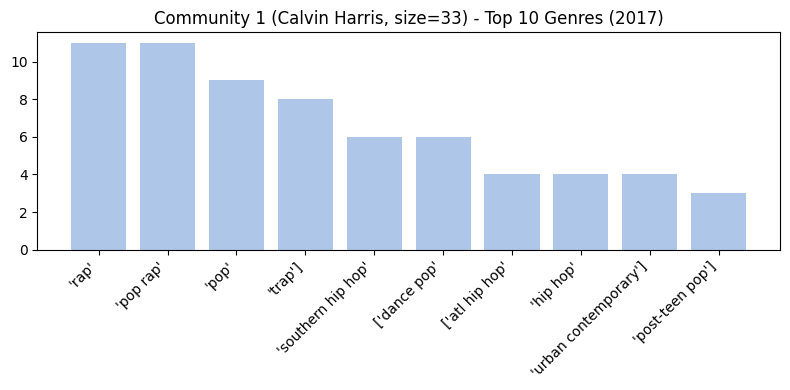

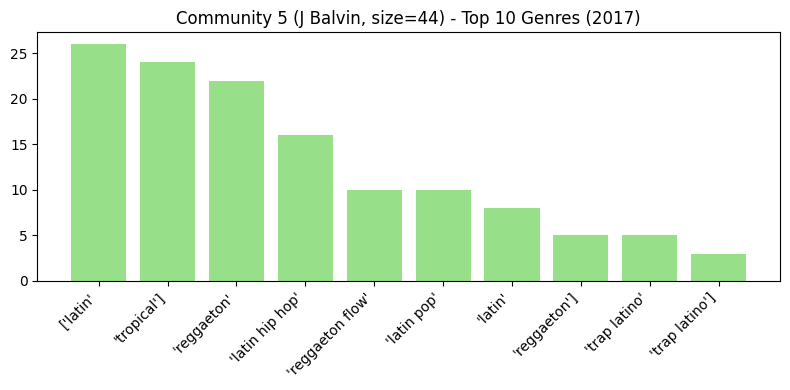

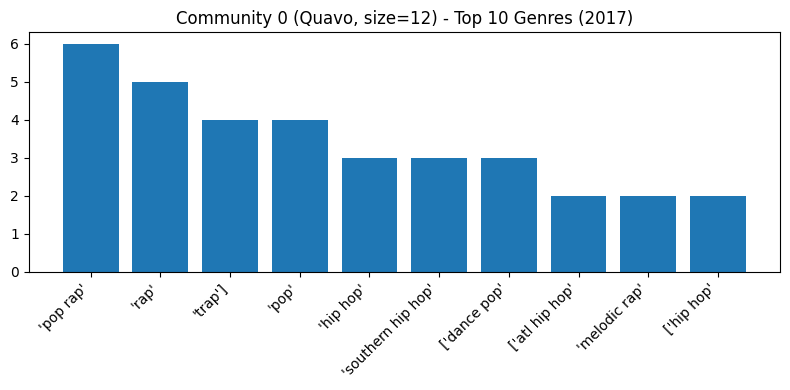

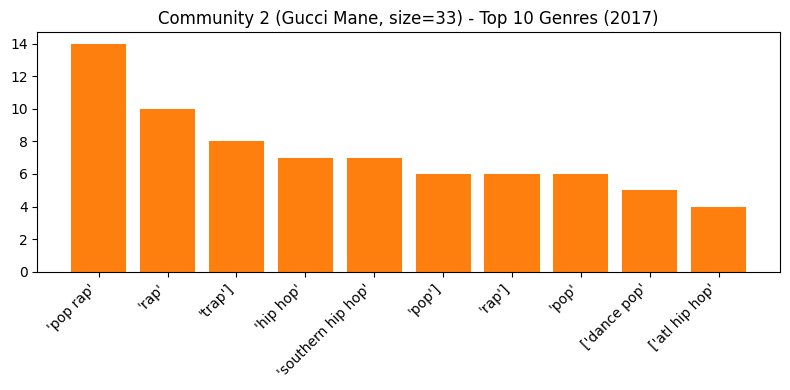

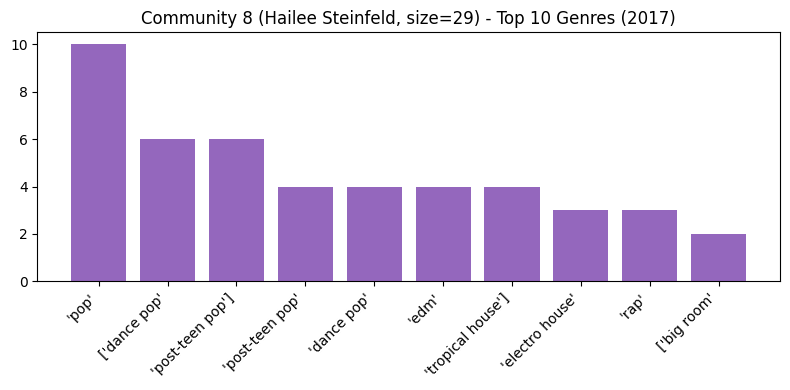

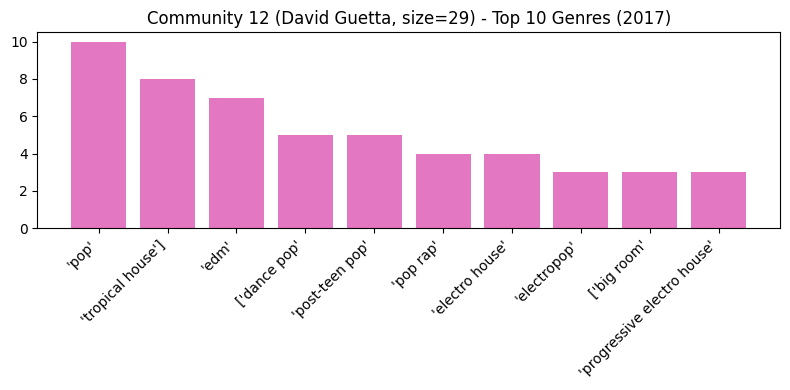

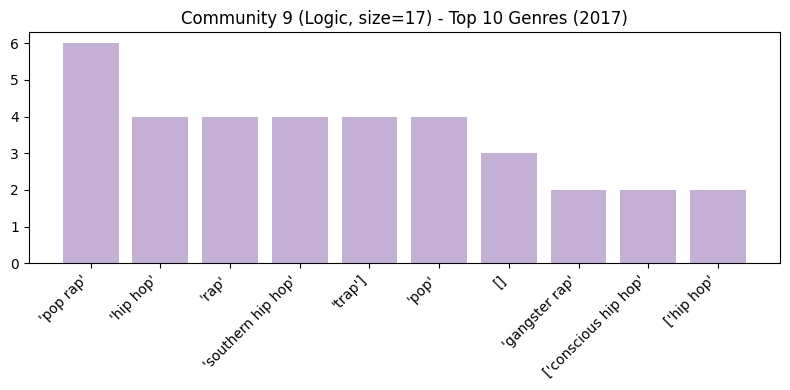

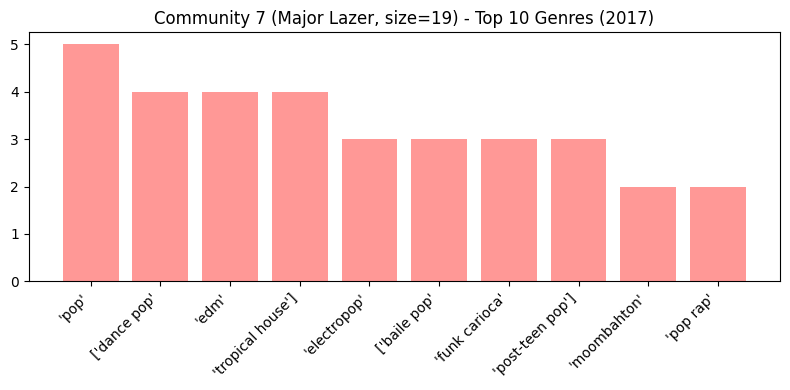

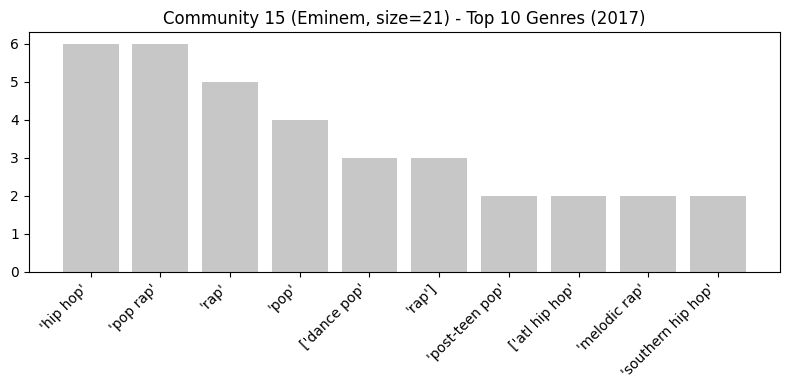

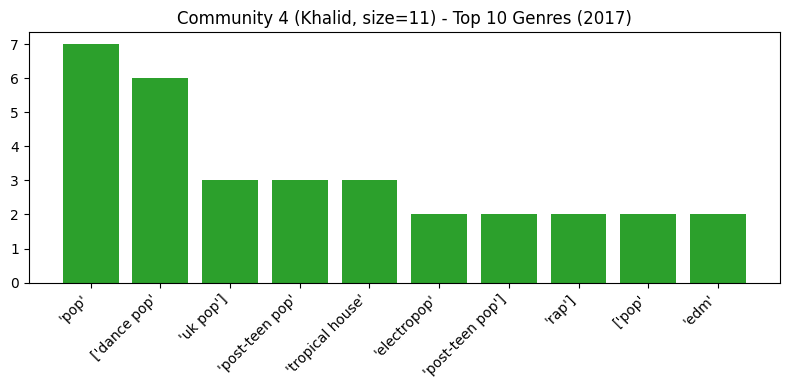

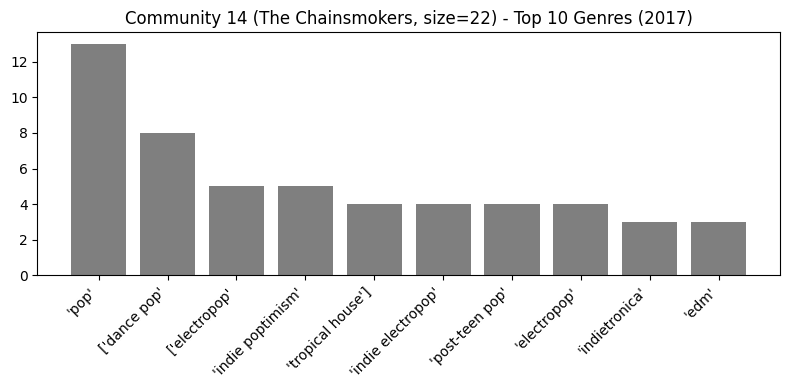

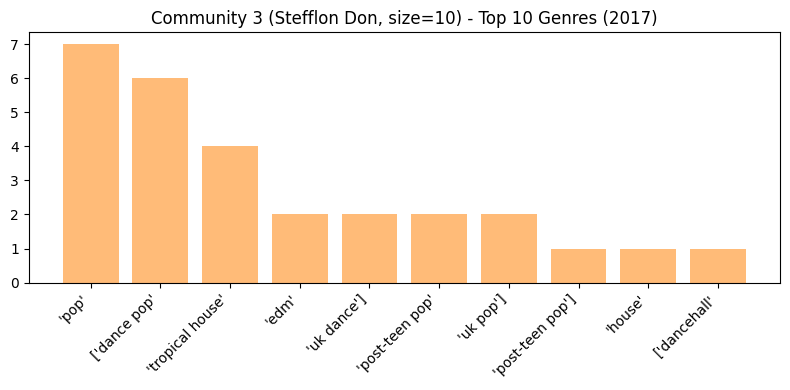

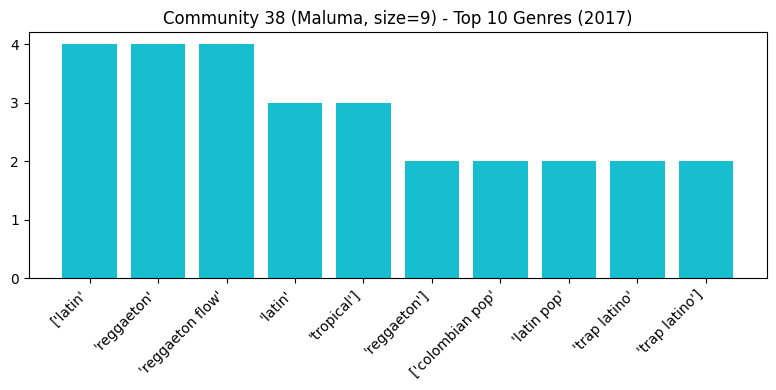

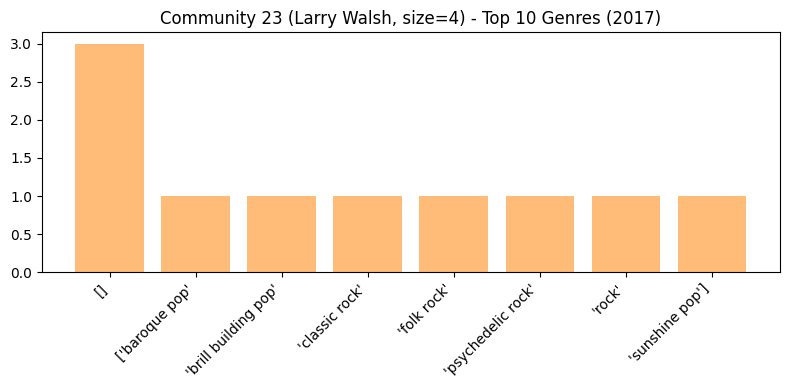

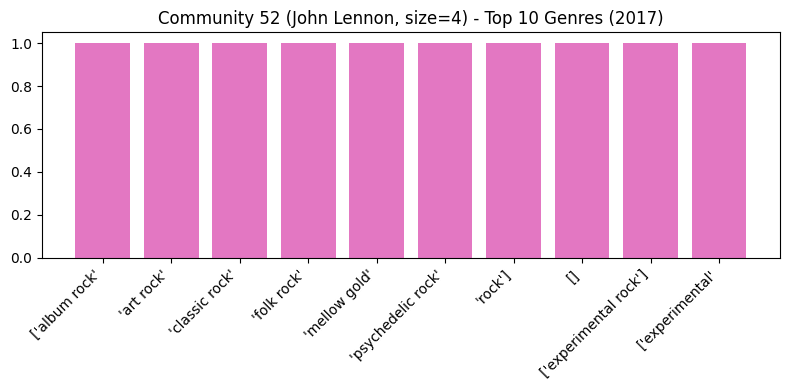

In [8]:

from collections import Counter


artists_info = pd.read_csv('/content/spotify_artists_info_complete.csv', sep='\t', encoding='utf-8')
artists_info = artists_info.drop_duplicates(subset=['name'], keep='first')
artist_genre_map = artists_info.set_index('name')['genres'].to_dict()

df = pd.read_csv('/content/global-artist_network-2017.csv', sep='\t', engine='python', quoting=3)
df.columns = df.columns.str.strip()
edges = df[['artist_1', 'artist_2', 'count']].dropna()
edges['count'] = pd.to_numeric(edges['count'], errors='coerce').fillna(1).astype(int)
G = nx.Graph()
for _, row in edges.iterrows():
    G.add_edge(row['artist_1'], row['artist_2'], weight=row['count'])
partition = community_louvain.best_partition(G, weight='weight')
nx.set_node_attributes(G, partition, 'community')
degrees = dict(G.degree(weight='weight'))

community_degree = {}
for comm in set(partition.values()):
    nodes = [n for n, c in partition.items() if c == comm]
    deg_sum = sum(dict(G.degree(nodes, weight='weight')).values())
    community_degree[comm] = deg_sum

top_15_communities = sorted(community_degree, key=community_degree.get, reverse=True)[:15]

nodes_data = []
for node in G.nodes():
    deg = degrees.get(node, 0)
    comm = partition.get(node, -1)
    nodes_data.append({'artist': node, 'degree': deg, 'community': comm})
nodes_df = pd.DataFrame(nodes_data)
rep_artist_df = nodes_df[nodes_df['community'].isin(top_15_communities)] \
    .groupby('community').apply(lambda x: x.nlargest(1, 'degree')).reset_index(drop=True)
rep_artist_names = rep_artist_df.set_index('community')['artist'].to_dict()
community_sizes = nodes_df['community'].value_counts().to_dict()

community_genres = {}
for node, comm in partition.items():
    if comm in top_15_communities:
        genres = artist_genre_map.get(node, '')
        for genre in str(genres).split(','):
            if comm not in community_genres:
                community_genres[comm] = []
            community_genres[comm].append(genre.strip())

cmap = plt.get_cmap('tab20')
for comm in top_15_communities:
    if comm in community_genres:
        genre_counts = Counter(community_genres[comm])
        top_genres = genre_counts.most_common(10)
        labels, counts = zip(*top_genres)
        rep_artist = rep_artist_names.get(comm, f'Community {comm}')
        comm_size = community_sizes.get(comm, 0)
        plt.figure(figsize=(8, 4))
        plt.bar(labels, counts, color=cmap(comm % 20))
        plt.title(f"Community {comm} ({rep_artist}, size={comm_size}) - Top 10 Genres (2017)")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
    else:
        print(f'Community {comm} has no genre data.')


<ipython-input-9-acf088ae25fb>:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .groupby('community').apply(lambda x: x.nlargest(1, 'degree')).reset_index(drop=True)


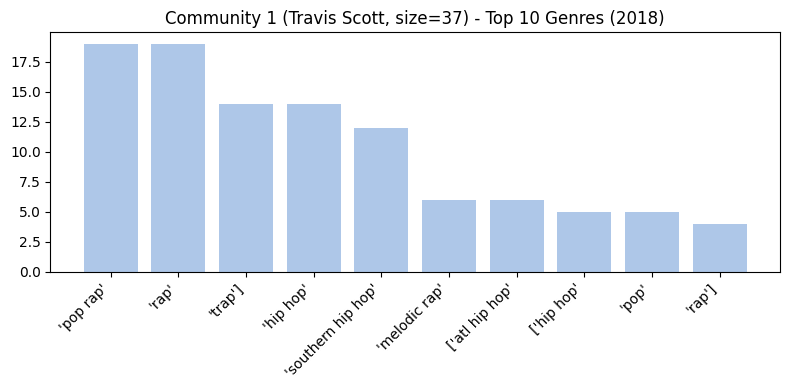

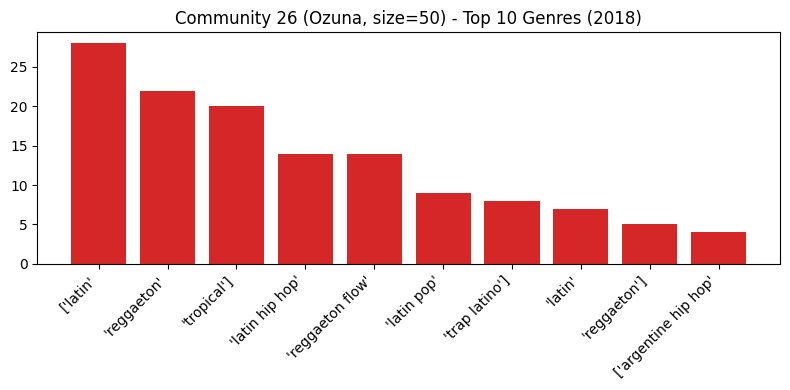

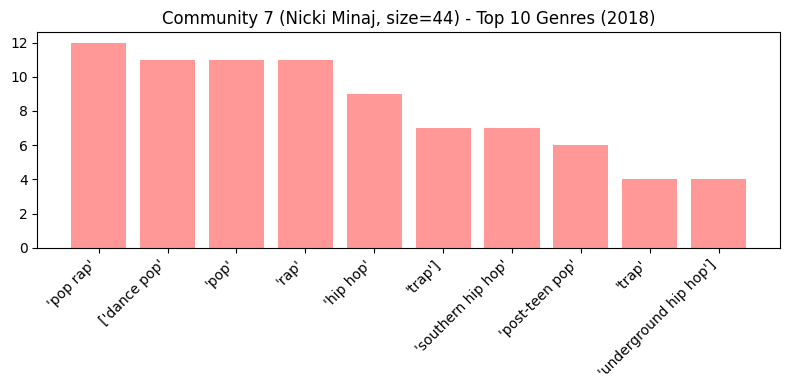

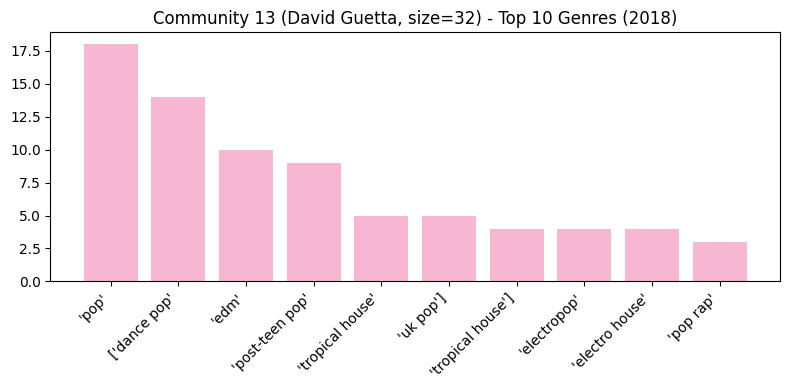

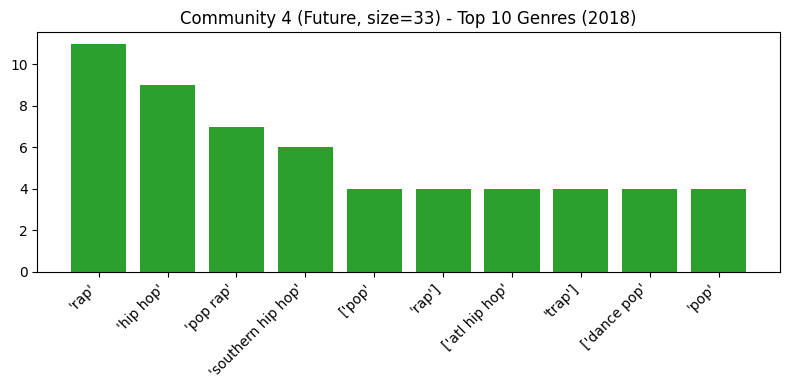

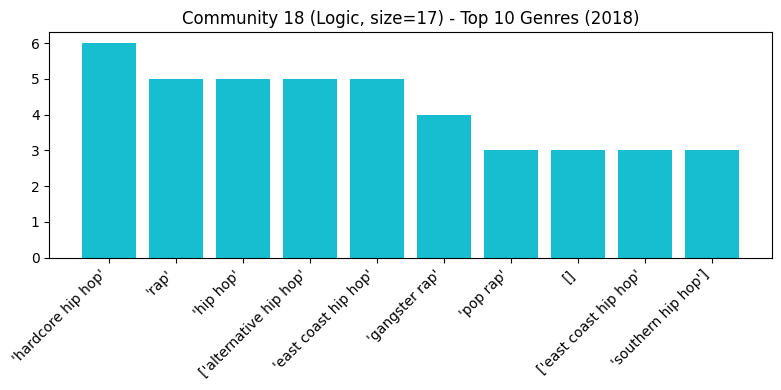

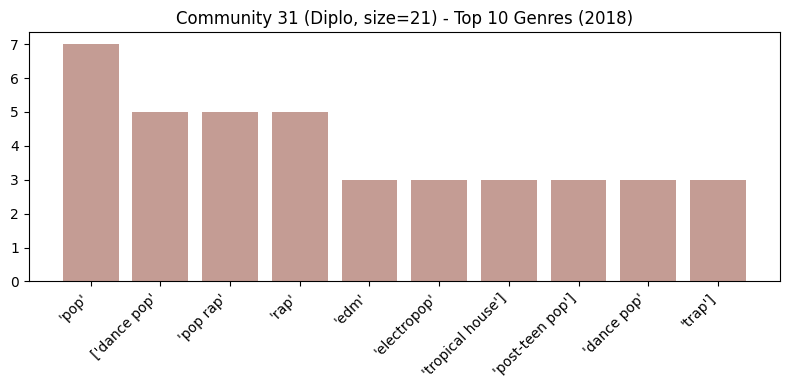

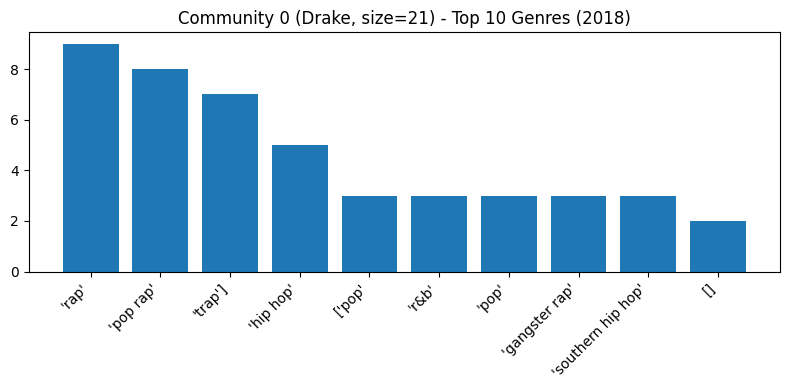

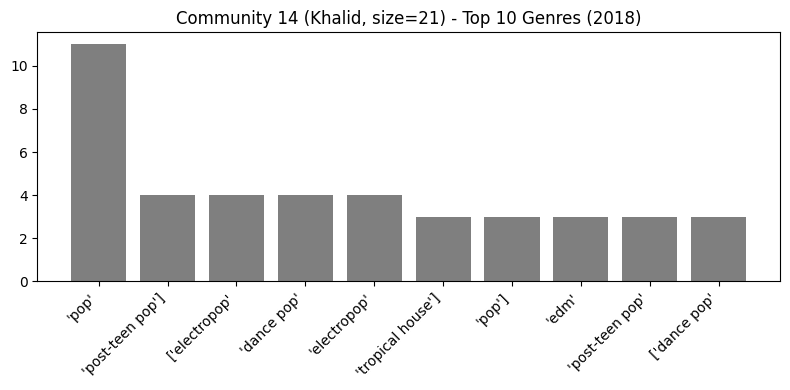

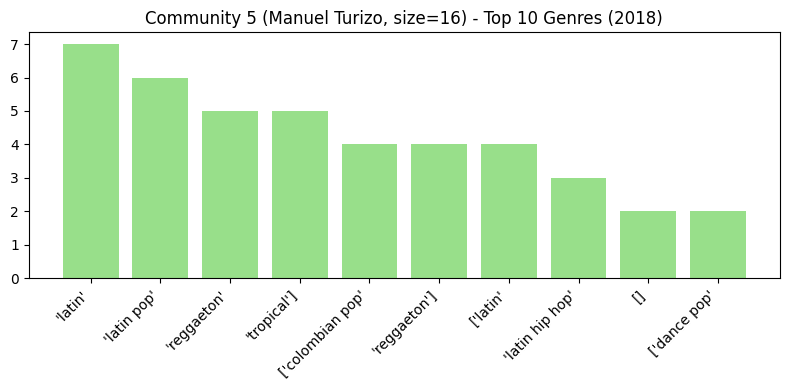

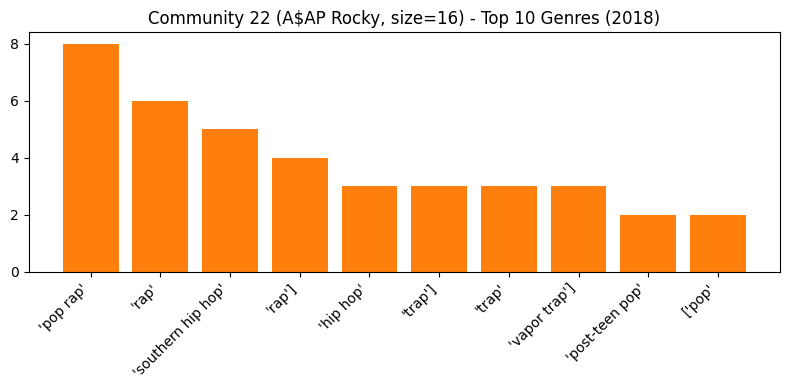

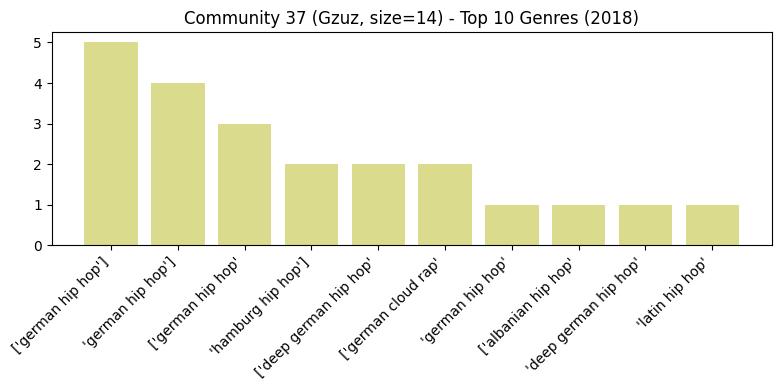

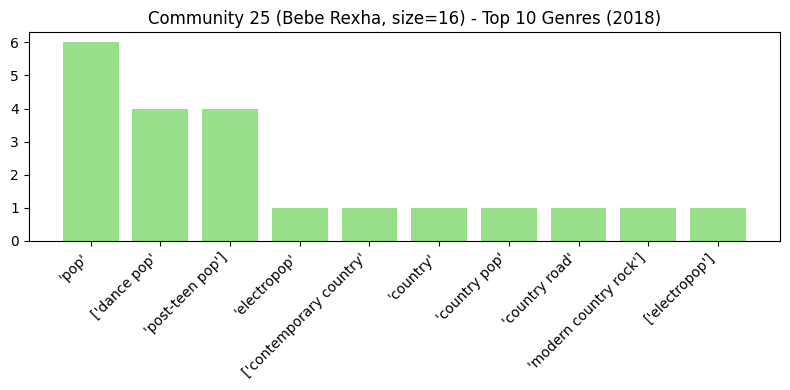

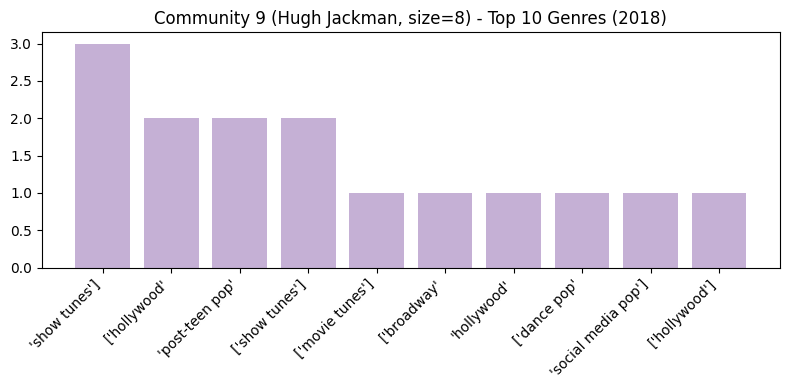

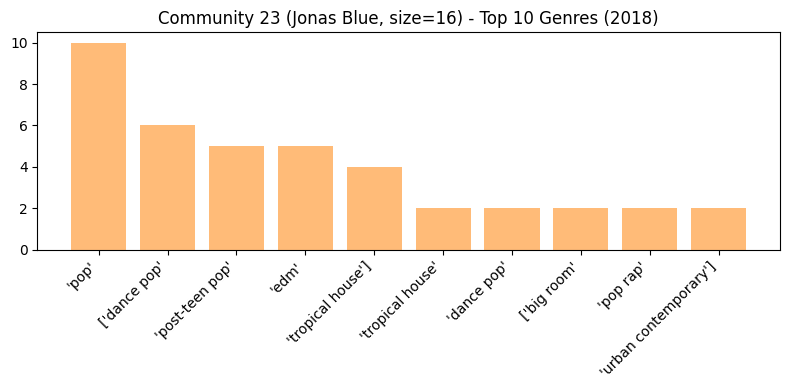

In [9]:

artists_info = pd.read_csv('/content/spotify_artists_info_complete.csv', sep='\t', encoding='utf-8')
artists_info = artists_info.drop_duplicates(subset=['name'], keep='first')
artist_genre_map = artists_info.set_index('name')['genres'].to_dict()

df = pd.read_csv('/content/global-artist_network-2018.csv', sep='\t', engine='python', quoting=3)
df.columns = df.columns.str.strip()
edges = df[['artist_1', 'artist_2', 'count']].dropna()
edges['count'] = pd.to_numeric(edges['count'], errors='coerce').fillna(1).astype(int)
G = nx.Graph()
for _, row in edges.iterrows():
    G.add_edge(row['artist_1'], row['artist_2'], weight=row['count'])
partition = community_louvain.best_partition(G, weight='weight')
nx.set_node_attributes(G, partition, 'community')
degrees = dict(G.degree(weight='weight'))

community_degree = {}
for comm in set(partition.values()):
    nodes = [n for n, c in partition.items() if c == comm]
    deg_sum = sum(dict(G.degree(nodes, weight='weight')).values())
    community_degree[comm] = deg_sum

top_15_communities = sorted(community_degree, key=community_degree.get, reverse=True)[:15]

nodes_data = []
for node in G.nodes():
    deg = degrees.get(node, 0)
    comm = partition.get(node, -1)
    nodes_data.append({'artist': node, 'degree': deg, 'community': comm})
nodes_df = pd.DataFrame(nodes_data)
rep_artist_df = nodes_df[nodes_df['community'].isin(top_15_communities)] \
    .groupby('community').apply(lambda x: x.nlargest(1, 'degree')).reset_index(drop=True)
rep_artist_names = rep_artist_df.set_index('community')['artist'].to_dict()
community_sizes = nodes_df['community'].value_counts().to_dict()

community_genres = {}
for node, comm in partition.items():
    if comm in top_15_communities:
        genres = artist_genre_map.get(node, '')
        for genre in str(genres).split(','):
            if comm not in community_genres:
                community_genres[comm] = []
            community_genres[comm].append(genre.strip())

cmap = plt.get_cmap('tab20')
for comm in top_15_communities:
    if comm in community_genres:
        genre_counts = Counter(community_genres[comm])
        top_genres = genre_counts.most_common(10)
        labels, counts = zip(*top_genres)
        rep_artist = rep_artist_names.get(comm, f'Community {comm}')
        comm_size = community_sizes.get(comm, 0)
        plt.figure(figsize=(8, 4))
        plt.bar(labels, counts, color=cmap(comm % 20))
        plt.title(f"Community {comm} ({rep_artist}, size={comm_size}) - Top 10 Genres (2018)")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
    else:
        print(f'Community {comm} has no genre data.')


<ipython-input-10-7a50f8631d03>:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .groupby('community').apply(lambda x: x.nlargest(1, 'degree')).reset_index(drop=True)


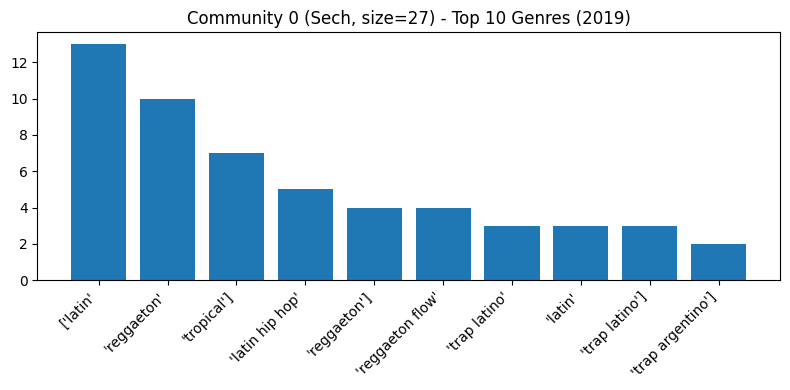

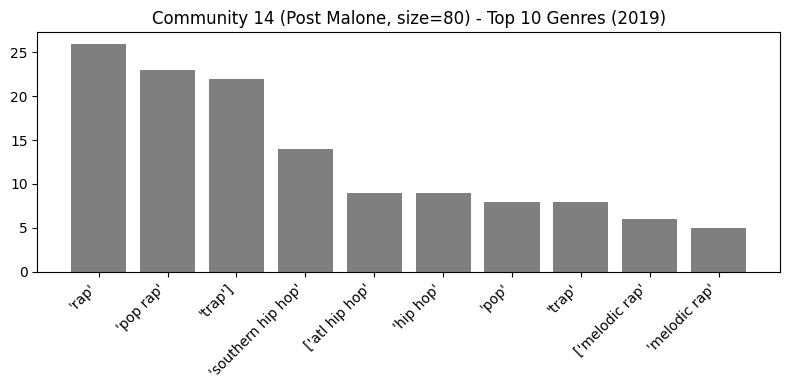

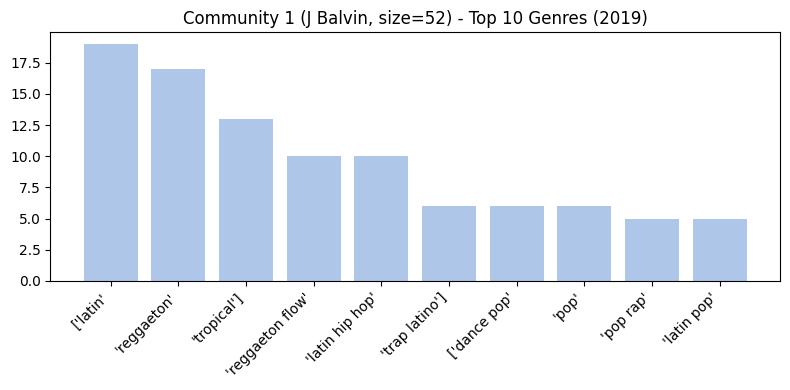

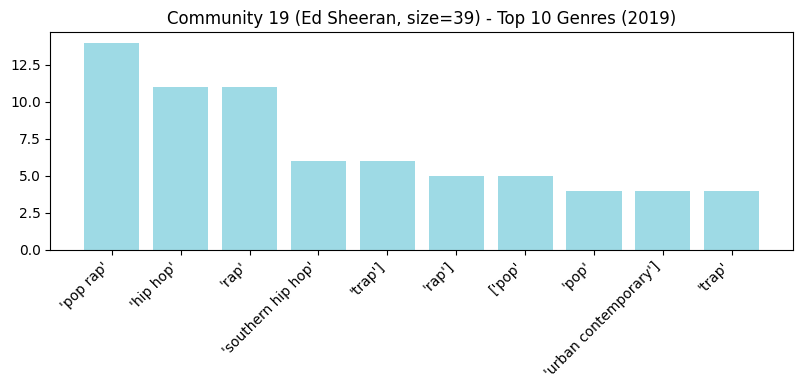

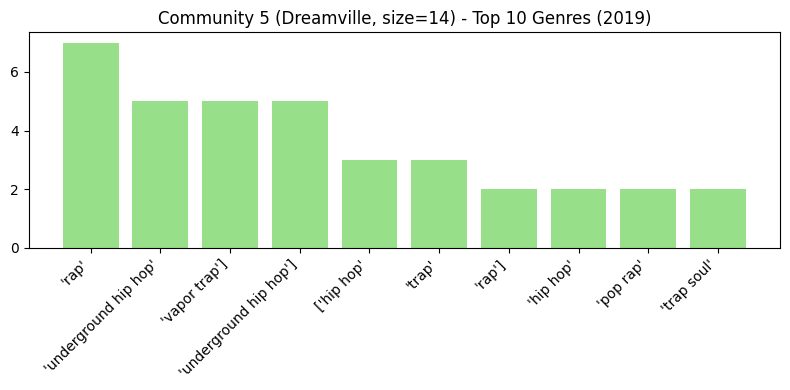

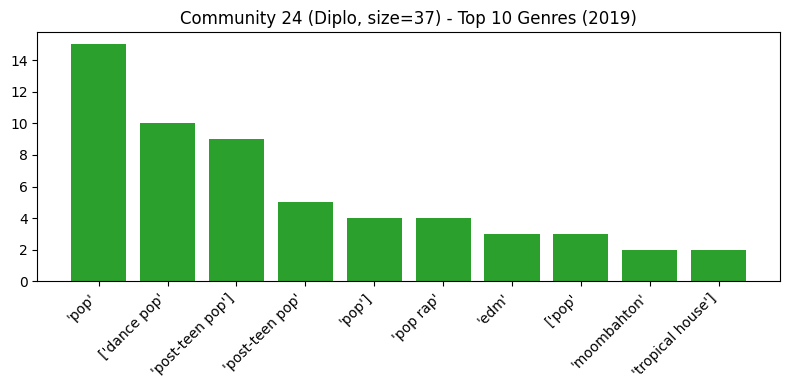

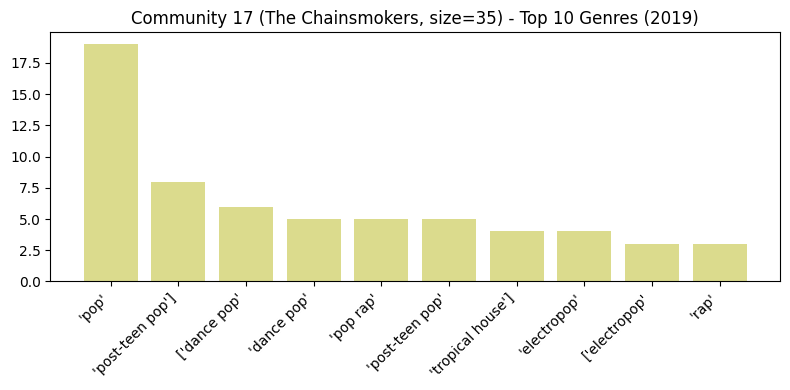

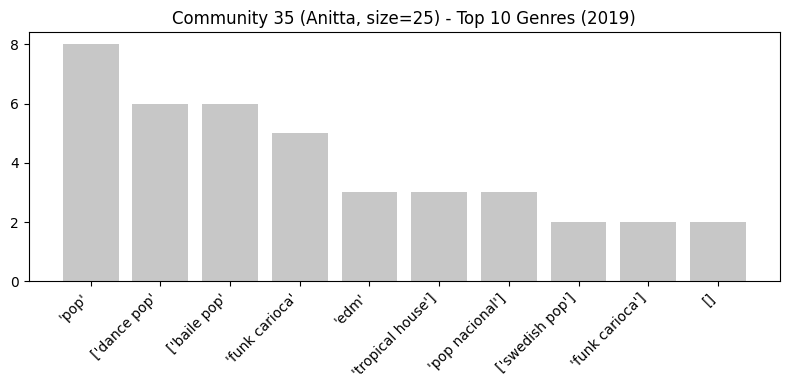

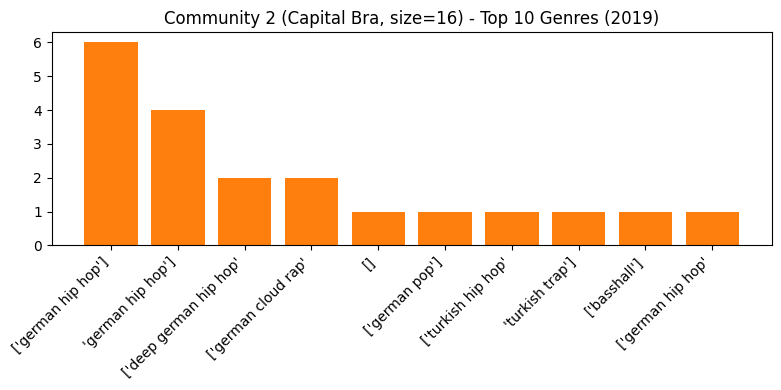

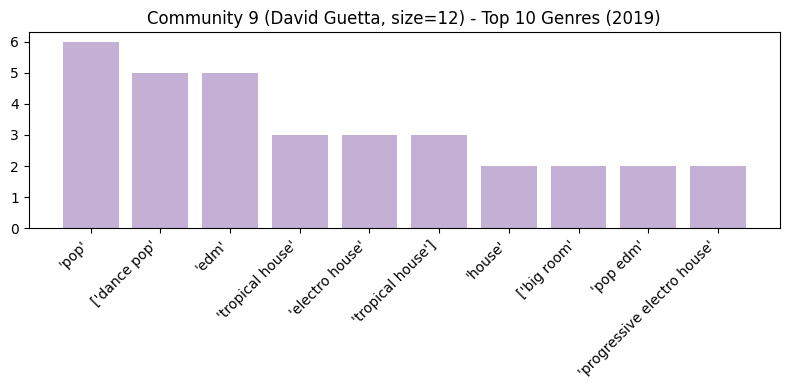

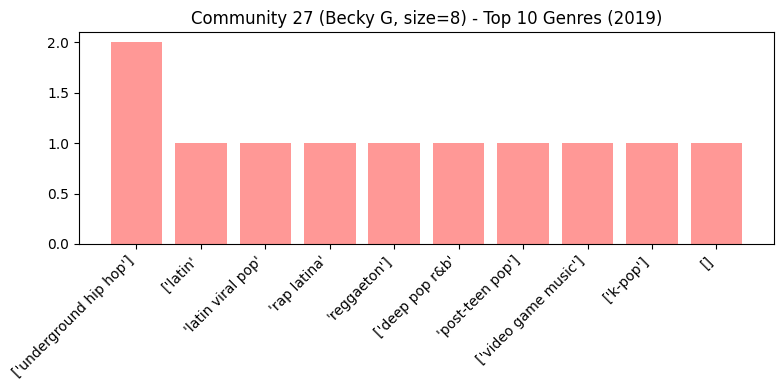

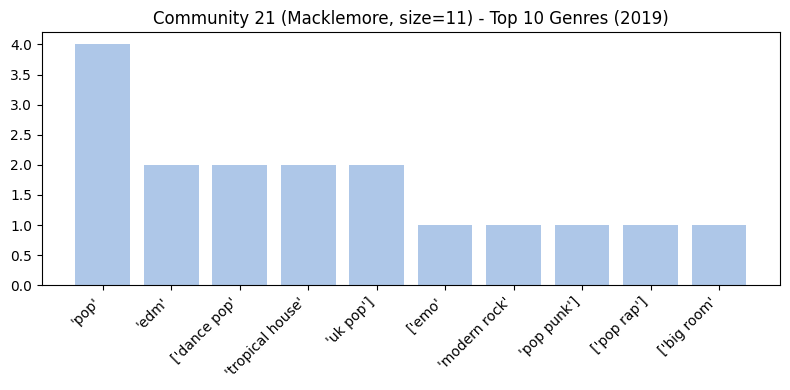

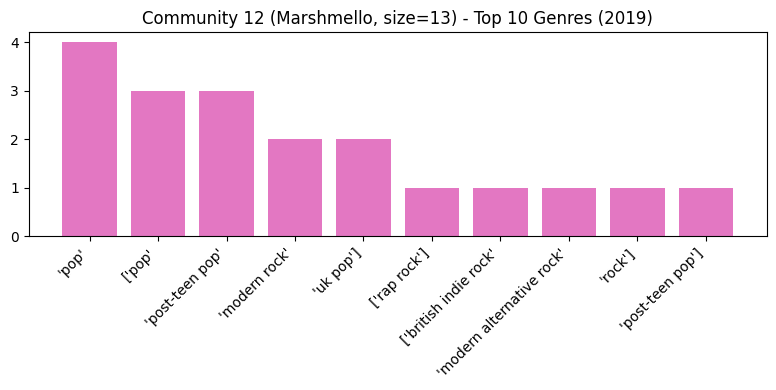

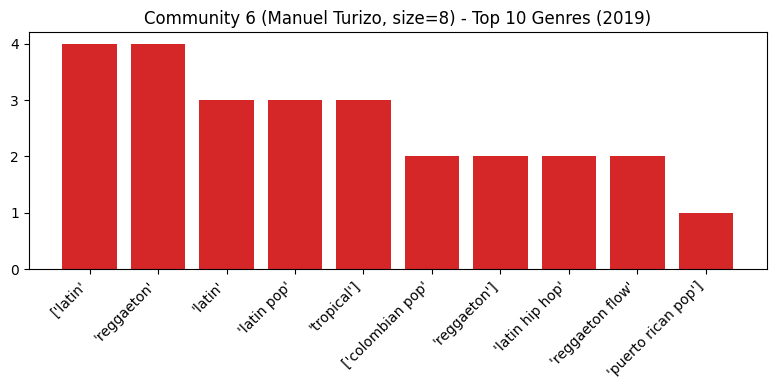

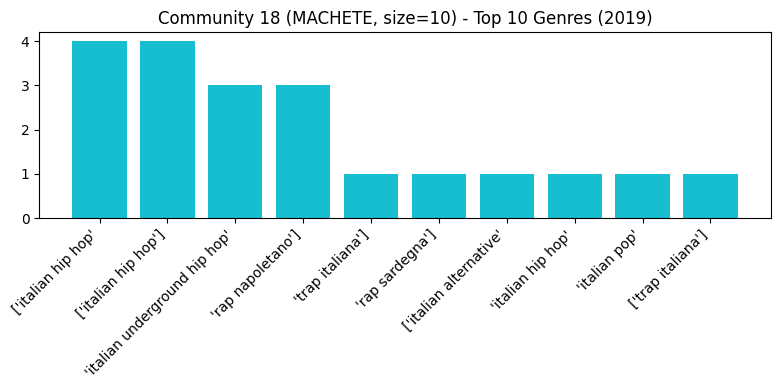

In [10]:

artists_info = pd.read_csv('/content/spotify_artists_info_complete.csv', sep='\t', encoding='utf-8')
artists_info = artists_info.drop_duplicates(subset=['name'], keep='first')
artist_genre_map = artists_info.set_index('name')['genres'].to_dict()


df = pd.read_csv('/content/global-artist_network-2019.csv', sep='\t', engine='python', quoting=3)
df.columns = df.columns.str.strip()
edges = df[['artist_1', 'artist_2', 'count']].dropna()
edges['count'] = pd.to_numeric(edges['count'], errors='coerce').fillna(1).astype(int)
G = nx.Graph()
for _, row in edges.iterrows():
    G.add_edge(row['artist_1'], row['artist_2'], weight=row['count'])
partition = community_louvain.best_partition(G, weight='weight')
nx.set_node_attributes(G, partition, 'community')
degrees = dict(G.degree(weight='weight'))

community_degree = {}
for comm in set(partition.values()):
    nodes = [n for n, c in partition.items() if c == comm]
    deg_sum = sum(dict(G.degree(nodes, weight='weight')).values())
    community_degree[comm] = deg_sum

top_15_communities = sorted(community_degree, key=community_degree.get, reverse=True)[:15]

nodes_data = []
for node in G.nodes():
    deg = degrees.get(node, 0)
    comm = partition.get(node, -1)
    nodes_data.append({'artist': node, 'degree': deg, 'community': comm})
nodes_df = pd.DataFrame(nodes_data)
rep_artist_df = nodes_df[nodes_df['community'].isin(top_15_communities)] \
    .groupby('community').apply(lambda x: x.nlargest(1, 'degree')).reset_index(drop=True)
rep_artist_names = rep_artist_df.set_index('community')['artist'].to_dict()
community_sizes = nodes_df['community'].value_counts().to_dict()

community_genres = {}
for node, comm in partition.items():
    if comm in top_15_communities:
        genres = artist_genre_map.get(node, '')
        for genre in str(genres).split(','):
            if comm not in community_genres:
                community_genres[comm] = []
            community_genres[comm].append(genre.strip())

cmap = plt.get_cmap('tab20')
for comm in top_15_communities:
    if comm in community_genres:
        genre_counts = Counter(community_genres[comm])
        top_genres = genre_counts.most_common(10)
        labels, counts = zip(*top_genres)
        rep_artist = rep_artist_names.get(comm, f'Community {comm}')
        comm_size = community_sizes.get(comm, 0)
        plt.figure(figsize=(8, 4))
        plt.bar(labels, counts, color=cmap(comm % 20))
        plt.title(f"Community {comm} ({rep_artist}, size={comm_size}) - Top 10 Genres (2019)")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
    else:
        print(f'Community {comm} has no genre data.')


# Genre Network Analysis


In this section, we aim to analyse the network of genres. We will first obtain an overview of the graph's nodes and edges, then use NetworkX to construct the graph and matplotlib for the visualisation.

In [11]:
import pandas as pd
import networkx as nx
from collections import Counter

# 1. Load files
artist_network = pd.read_csv('/content/global-artist_network-2017.csv', sep='\t', engine='python', quoting=3)
artists_info = pd.read_csv('/content/spotify_artists_info_complete.csv', sep='\t', encoding='utf-8')
artists_info = artists_info.drop_duplicates(subset=['name'], keep='first')
artist_genre_map = artists_info.set_index('name')['genres'].to_dict()

# 2. Build genre network
genre_G = nx.Graph()

for idx, row in artist_network.iterrows():
    a1, a2, count = row['artist_1'], row['artist_2'], row['count']
    genres1 = artist_genre_map.get(a1, '')
    genres2 = artist_genre_map.get(a2, '')
    # If genres are stored as strings, split by comma (or whitespace if needed)
    if isinstance(genres1, str):
        genres1 = [g.strip() for g in genres1.replace("'", "").replace("[", "").replace("]", "").split(',') if g.strip()]
    if isinstance(genres2, str):
        genres2 = [g.strip() for g in genres2.replace("'", "").replace("[", "").replace("]", "").split(',') if g.strip()]
    # Create all genre pairs
    for g1 in genres1:
        for g2 in genres2:
            if not g1 or not g2:
                continue
            # Undirected network: sort alphabetically to avoid duplicates
            edge = tuple(sorted([g1, g2]))
            if genre_G.has_edge(edge[0], edge[1]):
                genre_G[edge[0]][edge[1]]['weight'] += int(count)
            else:
                genre_G.add_edge(edge[0], edge[1], weight=int(count))

print(f"Number of genre nodes: {genre_G.number_of_nodes()}")
print(f"Number of genre edges: {genre_G.number_of_edges()}")

# Print top genre collaboration pairs
top_edges = sorted(genre_G.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)[:15]
print("\nTop 15 genre-genre collaborations:")
for g1, g2, data in top_edges:
    print(f"{g1} - {g2}: {data['weight']}")

Number of genre nodes: 258
Number of genre edges: 2643

Top 15 genre-genre collaborations:
rap - pop rap: 326
rap - trap: 268
rap - hip hop: 250
pop rap - trap: 236
dance pop - pop: 223
pop rap - pop: 216
hip hop - pop rap: 214
rap - pop: 207
rap - rap: 184
hip hop - trap: 178
latin - reggaeton: 170
rap - southern hip hop: 165
pop - pop: 159
pop rap - pop rap: 146
pop rap - dance pop: 145


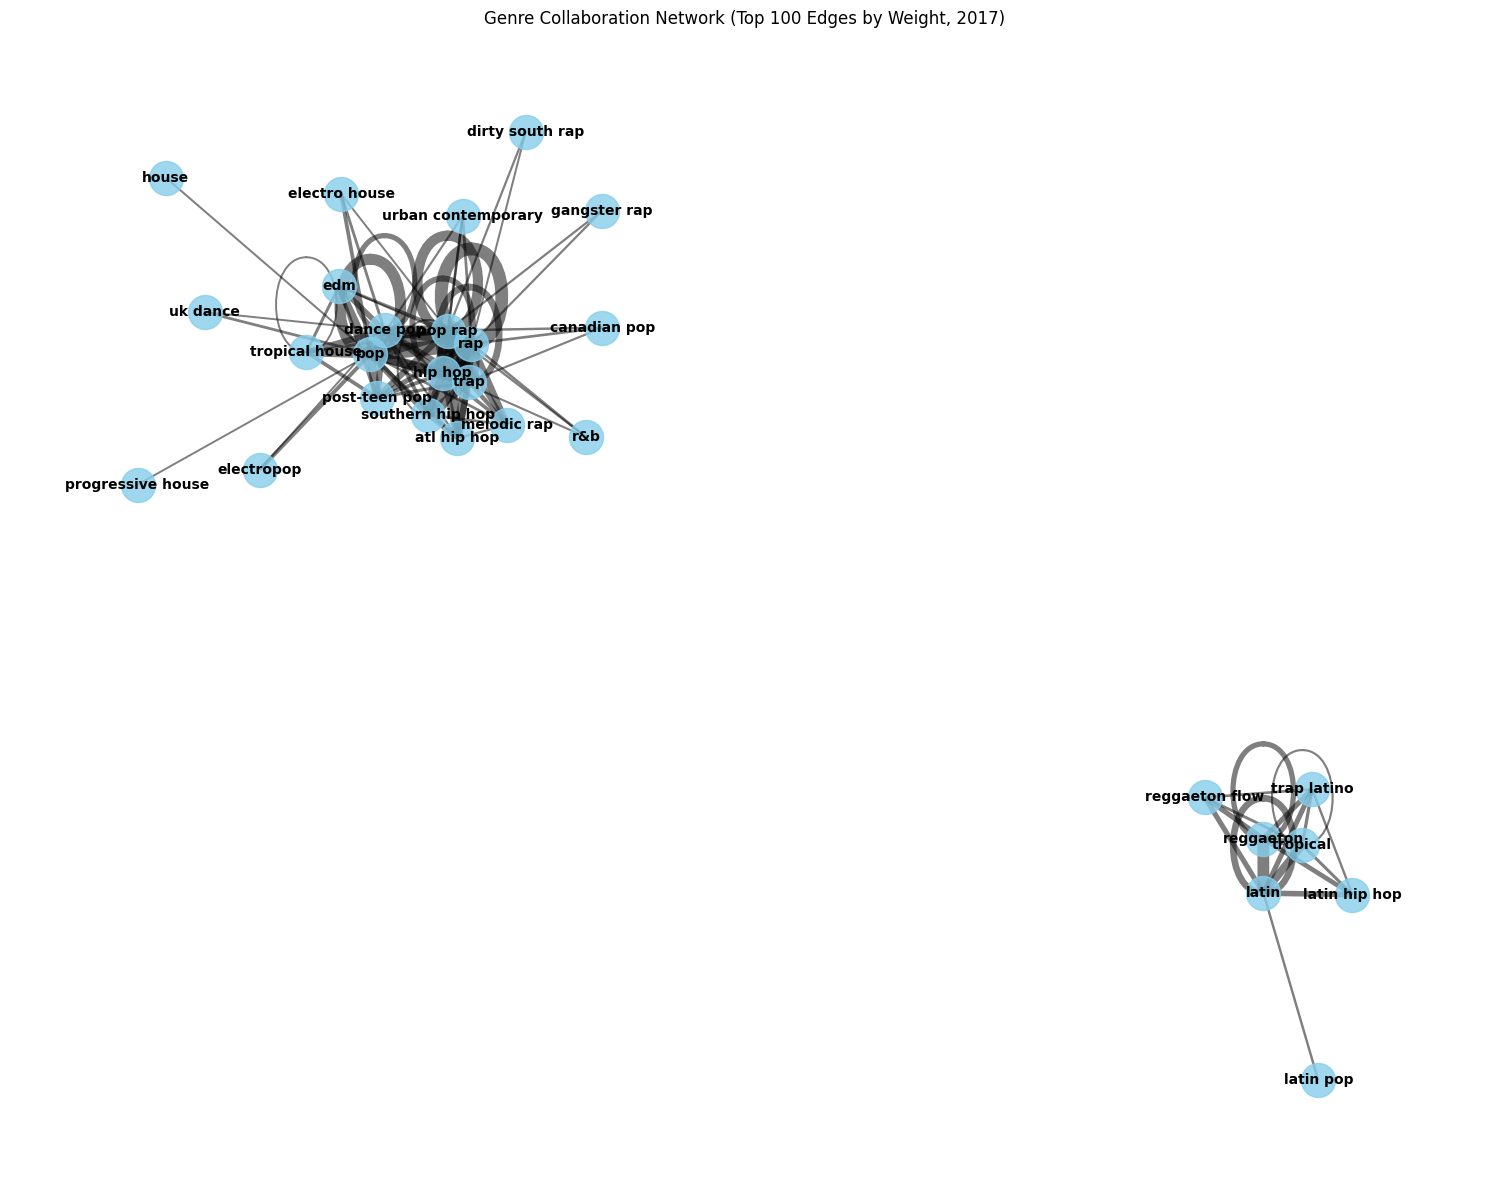

In [12]:

artist_network = pd.read_csv('/content/global-artist_network-2017.csv', sep='\t', engine='python', quoting=3)
artists_info = pd.read_csv('/content/spotify_artists_info_complete.csv', sep='\t', encoding='utf-8')
artists_info = artists_info.drop_duplicates(subset=['name'], keep='first')
artist_genre_map = artists_info.set_index('name')['genres'].to_dict()

genre_G = nx.Graph()
for idx, row in artist_network.iterrows():
    a1, a2, count = row['artist_1'], row['artist_2'], row['count']
    genres1 = artist_genre_map.get(a1, '')
    genres2 = artist_genre_map.get(a2, '')
    if isinstance(genres1, str):
        genres1 = [g.strip().strip("'[]") for g in genres1.split(',') if g.strip()]
    if isinstance(genres2, str):
        genres2 = [g.strip().strip("'[]") for g in genres2.split(',') if g.strip()]
    for g1 in genres1:
        for g2 in genres2:
            if not g1 or not g2:
                continue
            edge = tuple(sorted([g1, g2]))
            if genre_G.has_edge(*edge):
                genre_G[edge[0]][edge[1]]['weight'] += int(count)
            else:
                genre_G.add_edge(edge[0], edge[1], weight=int(count))

#show only top 100 edges by weight
edges_to_draw = sorted(genre_G.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)[:100]
subG = nx.Graph()
for g1, g2, data in edges_to_draw:
    subG.add_edge(g1, g2, weight=data['weight'])

plt.figure(figsize=(15, 12))
pos = nx.spring_layout(subG, k=0.8, seed=42)
edge_widths = [subG[u][v]['weight']*0.05 for u, v in subG.edges()]
nx.draw_networkx_nodes(subG, pos, node_color='skyblue', node_size=600, alpha=0.8)
nx.draw_networkx_edges(subG, pos, width=edge_widths, alpha=0.5)
nx.draw_networkx_labels(subG, pos, font_size=10, font_weight='bold')
plt.title('Genre Collaboration Network (Top 100 Edges by Weight, 2017)')
plt.axis('off')
plt.tight_layout()
plt.show()


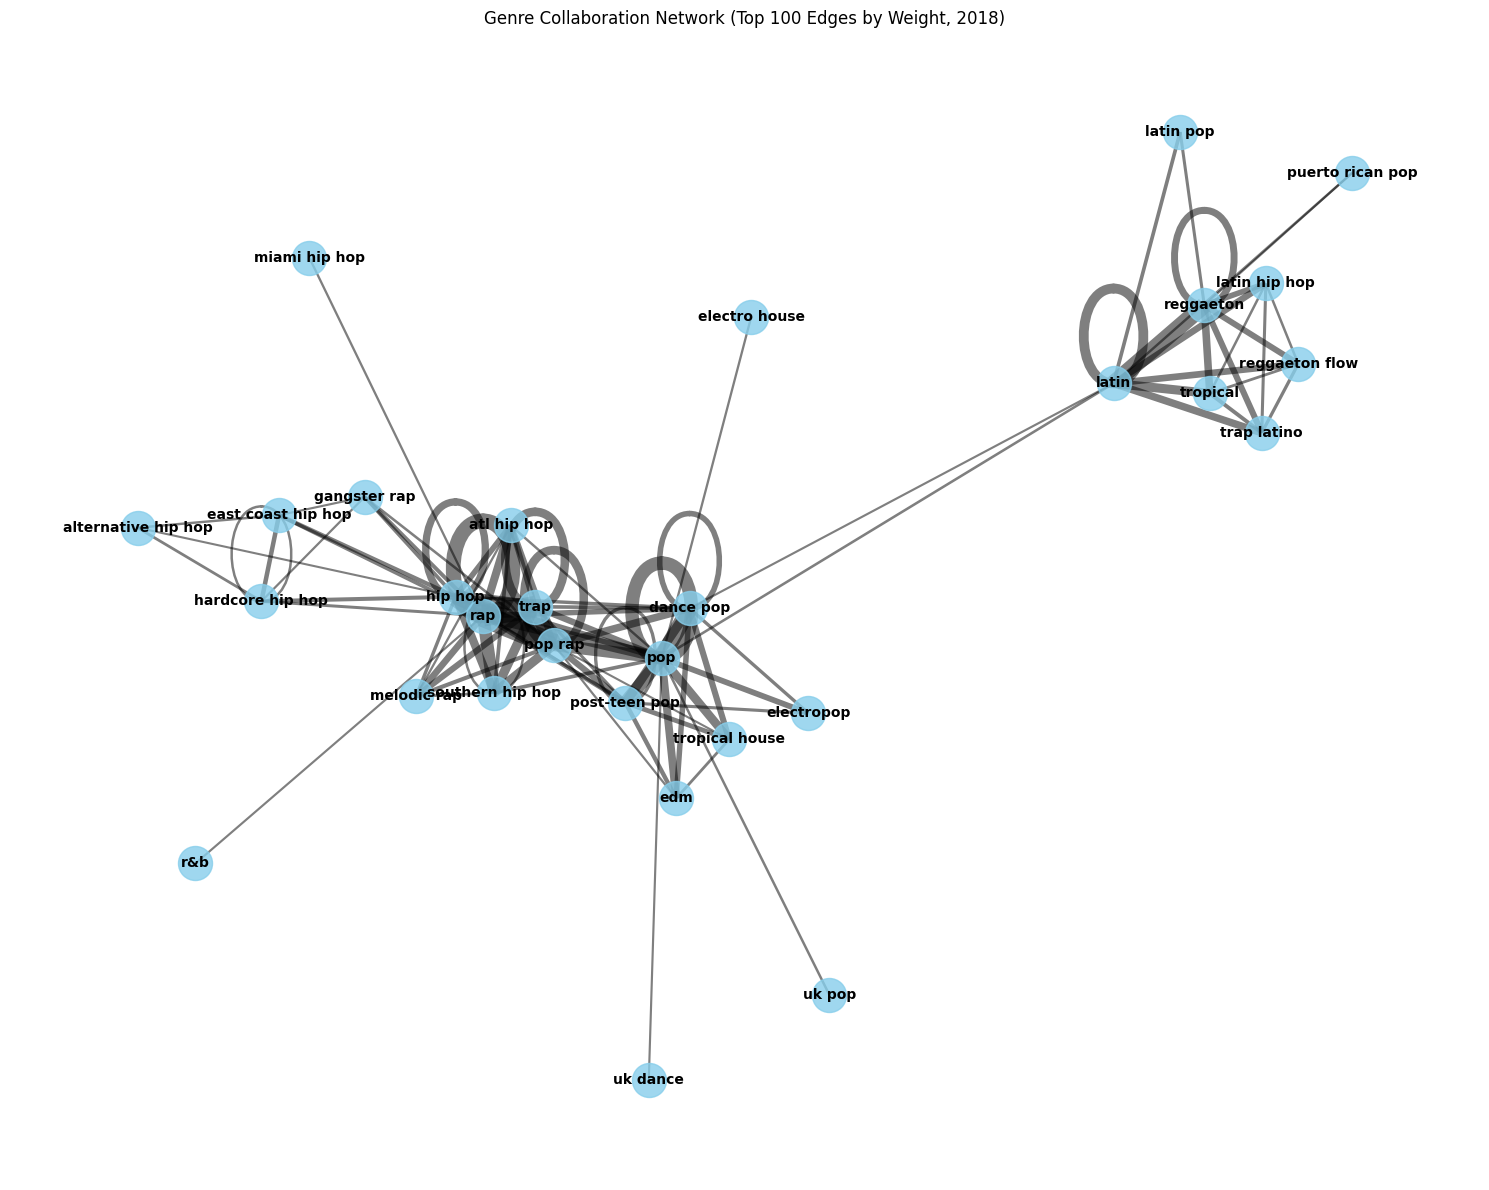

In [13]:

artist_network = pd.read_csv('/content/global-artist_network-2018.csv', sep='\t', engine='python', quoting=3)
artists_info = pd.read_csv('/content/spotify_artists_info_complete.csv', sep='\t', encoding='utf-8')
artists_info = artists_info.drop_duplicates(subset=['name'], keep='first')
artist_genre_map = artists_info.set_index('name')['genres'].to_dict()

genre_G = nx.Graph()
for idx, row in artist_network.iterrows():
    a1, a2, count = row['artist_1'], row['artist_2'], row['count']
    genres1 = artist_genre_map.get(a1, '')
    genres2 = artist_genre_map.get(a2, '')
    if isinstance(genres1, str):
        genres1 = [g.strip().strip("'[]") for g in genres1.split(',') if g.strip()]
    if isinstance(genres2, str):
        genres2 = [g.strip().strip("'[]") for g in genres2.split(',') if g.strip()]
    for g1 in genres1:
        for g2 in genres2:
            if not g1 or not g2:
                continue
            edge = tuple(sorted([g1, g2]))
            if genre_G.has_edge(*edge):
                genre_G[edge[0]][edge[1]]['weight'] += int(count)
            else:
                genre_G.add_edge(edge[0], edge[1], weight=int(count))

edges_to_draw = sorted(genre_G.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)[:100]
subG = nx.Graph()
for g1, g2, data in edges_to_draw:
    subG.add_edge(g1, g2, weight=data['weight'])

plt.figure(figsize=(15, 12))
pos = nx.spring_layout(subG, k=0.8, seed=42)
edge_widths = [subG[u][v]['weight']*0.05 for u, v in subG.edges()]
nx.draw_networkx_nodes(subG, pos, node_color='skyblue', node_size=600, alpha=0.8)
nx.draw_networkx_edges(subG, pos, width=edge_widths, alpha=0.5)
nx.draw_networkx_labels(subG, pos, font_size=10, font_weight='bold')
plt.title('Genre Collaboration Network (Top 100 Edges by Weight, 2018)')
plt.axis('off')
plt.tight_layout()
plt.show()


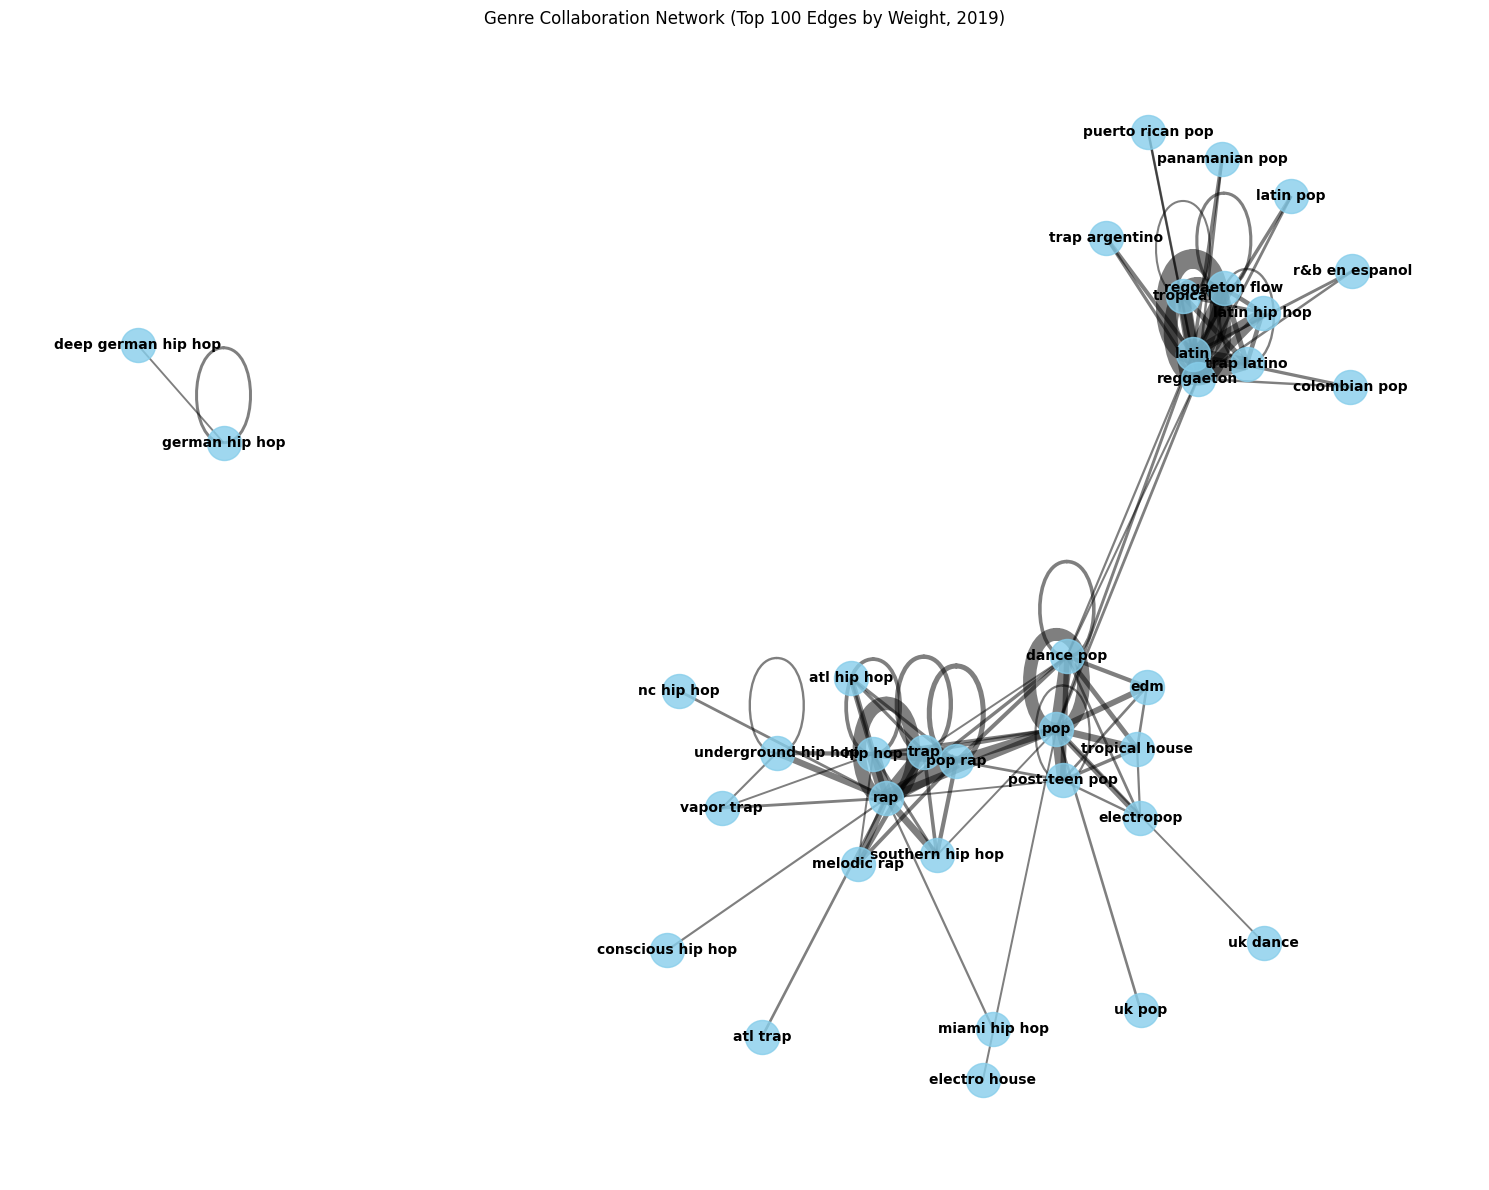

In [14]:

artist_network = pd.read_csv('/content/global-artist_network-2019.csv', sep='\t', engine='python', quoting=3)
artists_info = pd.read_csv('/content/spotify_artists_info_complete.csv', sep='\t', encoding='utf-8')
artists_info = artists_info.drop_duplicates(subset=['name'], keep='first')
artist_genre_map = artists_info.set_index('name')['genres'].to_dict()


genre_G = nx.Graph()
for idx, row in artist_network.iterrows():
    a1, a2, count = row['artist_1'], row['artist_2'], row['count']
    genres1 = artist_genre_map.get(a1, '')
    genres2 = artist_genre_map.get(a2, '')
    if isinstance(genres1, str):
        genres1 = [g.strip().strip("'[]") for g in genres1.split(',') if g.strip()]
    if isinstance(genres2, str):
        genres2 = [g.strip().strip("'[]") for g in genres2.split(',') if g.strip()]
    for g1 in genres1:
        for g2 in genres2:
            if not g1 or not g2:
                continue
            edge = tuple(sorted([g1, g2]))
            if genre_G.has_edge(*edge):
                genre_G[edge[0]][edge[1]]['weight'] += int(count)
            else:
                genre_G.add_edge(edge[0], edge[1], weight=int(count))

edges_to_draw = sorted(genre_G.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)[:100]
subG = nx.Graph()
for g1, g2, data in edges_to_draw:
    subG.add_edge(g1, g2, weight=data['weight'])

plt.figure(figsize=(15, 12))
pos = nx.spring_layout(subG, k=0.8, seed=42)
edge_widths = [subG[u][v]['weight']*0.05 for u, v in subG.edges()]
nx.draw_networkx_nodes(subG, pos, node_color='skyblue', node_size=600, alpha=0.8)
nx.draw_networkx_edges(subG, pos, width=edge_widths, alpha=0.5)
nx.draw_networkx_labels(subG, pos, font_size=10, font_weight='bold')
plt.title('Genre Collaboration Network (Top 100 Edges by Weight, 2019)')
plt.axis('off')
plt.tight_layout()
plt.show()



=== 2017 Genre Network Analysis ===
Community 1: #genres=66, entropy=6.04, top genres=[('atl hip hop', 1), ('rap', 1), ('hip hop', 1), ('melodic rap', 1), ('pop rap', 1)]
Community 7: #genres=12, entropy=3.58, top genres=[('detroit hip hop', 1), ('g funk', 1), ('brazilian edm', 1), ('pop nacional', 1), ('baile pop', 1)]
Community 6: #genres=113, entropy=6.82, top genres=[('dance pop', 1), ('edm', 1), ('house', 1), ('pop', 1), ('tropical house', 1)]
Community 0: #genres=30, entropy=4.91, top genres=[('latin', 1), ('latin hip hop', 1), ('reggaeton', 1), ('reggaeton flow', 1), ('tropical', 1)]
Community 2: #genres=4, entropy=2.00, top genres=[('vapor soul', 1), ('indie r&b', 1), ('bedroom pop', 1), ('vapor pop', 1)]
Community 4: #genres=7, entropy=2.81, top genres=[('celtic', 1), ('new wave pop', 1), ('celtic punk', 1), ('celtic rock', 1), ('folk punk', 1)]
Community 5: #genres=3, entropy=1.58, top genres=[('deep german hip hop', 1), ('german hip hop', 1), ('hamburg hip hop', 1)]
Communi

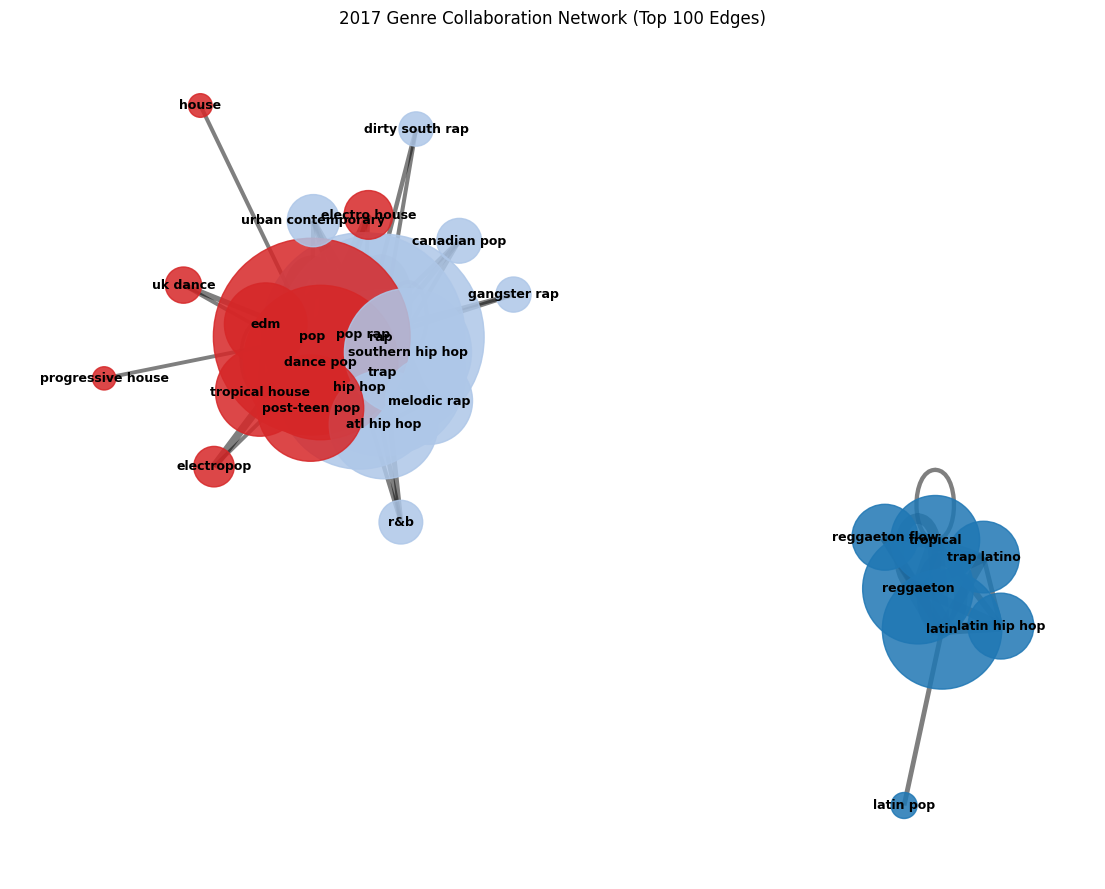


Hub/Bridge genres (top 10 by participation_coeff, betweenness):
               genre  community  degree_centrality  participation_coeff  \
117     funk carioca          7           0.140078             0.730710   
234      spanish pop          0           0.062257             0.695312   
23      uk dancehall          6           0.073930             0.692521   
114    brazilian edm          7           0.015564             0.687500   
126   electro latino          0           0.073930             0.681440   
22         dancehall          6           0.101167             0.674556   
12   detroit hip hop          7           0.175097             0.665185   
116        baile pop          7           0.097276             0.664000   
153       trap queen          1           0.038911             0.660000   
42      canadian pop          1           0.299611             0.642773   

     betweenness  
117     0.008566  
234     0.009769  
23      0.000815  
114     0.000000  
126     0.0148

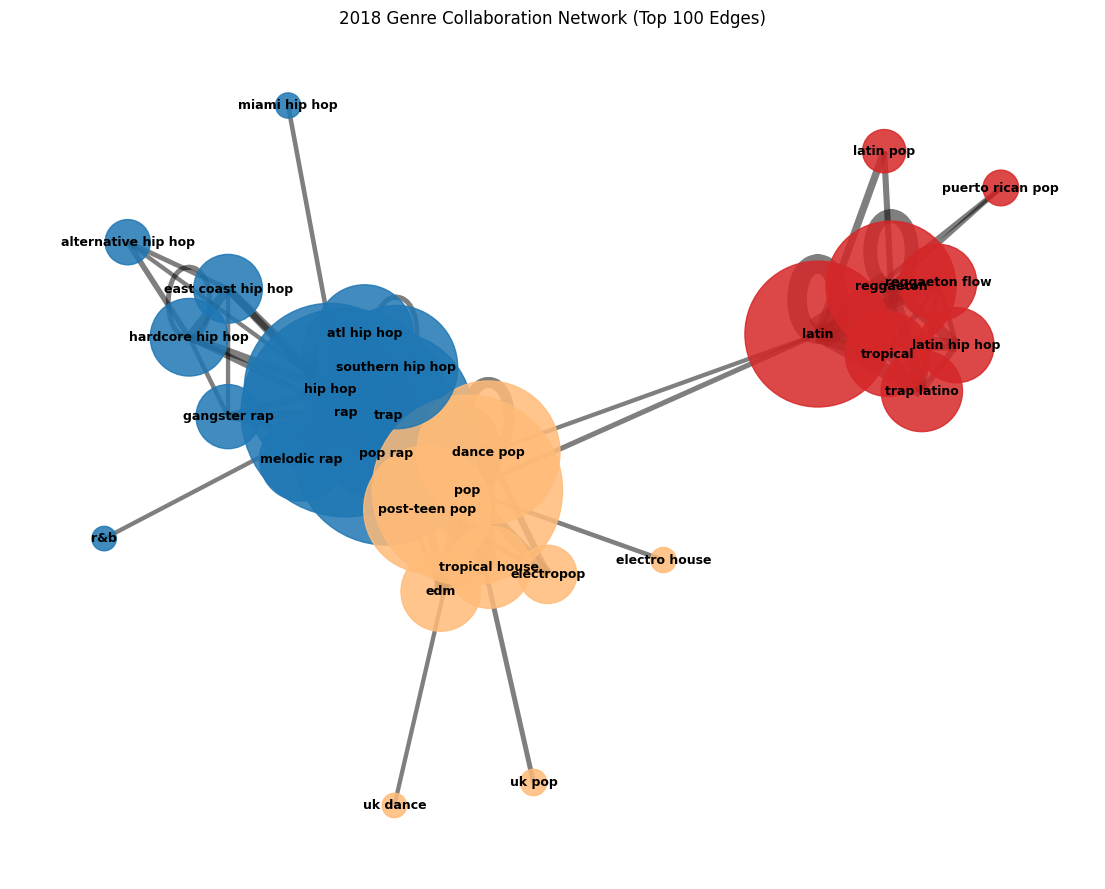


Hub/Bridge genres (top 10 by participation_coeff, betweenness):
               genre  community  degree_centrality  participation_coeff  \
87   italian hip hop          5           0.078231             0.716446   
113  adult standards          2           0.068027             0.677500   
284     zimdancehall          6           0.030612             0.666667   
7     german hip hop          1           0.064626             0.662050   
39      canadian pop          0           0.238095             0.658571   
102  electronic trap          6           0.088435             0.653846   
251     uk dancehall          6           0.061224             0.648148   
253       uk hip hop          6           0.061224             0.648148   
77         dancehall          6           0.078231             0.642722   
52         latin pop          6           0.173469             0.634756   

     betweenness  
87      0.041277  
113     0.019804  
284     0.002714  
7       0.006969  
39      0.0299

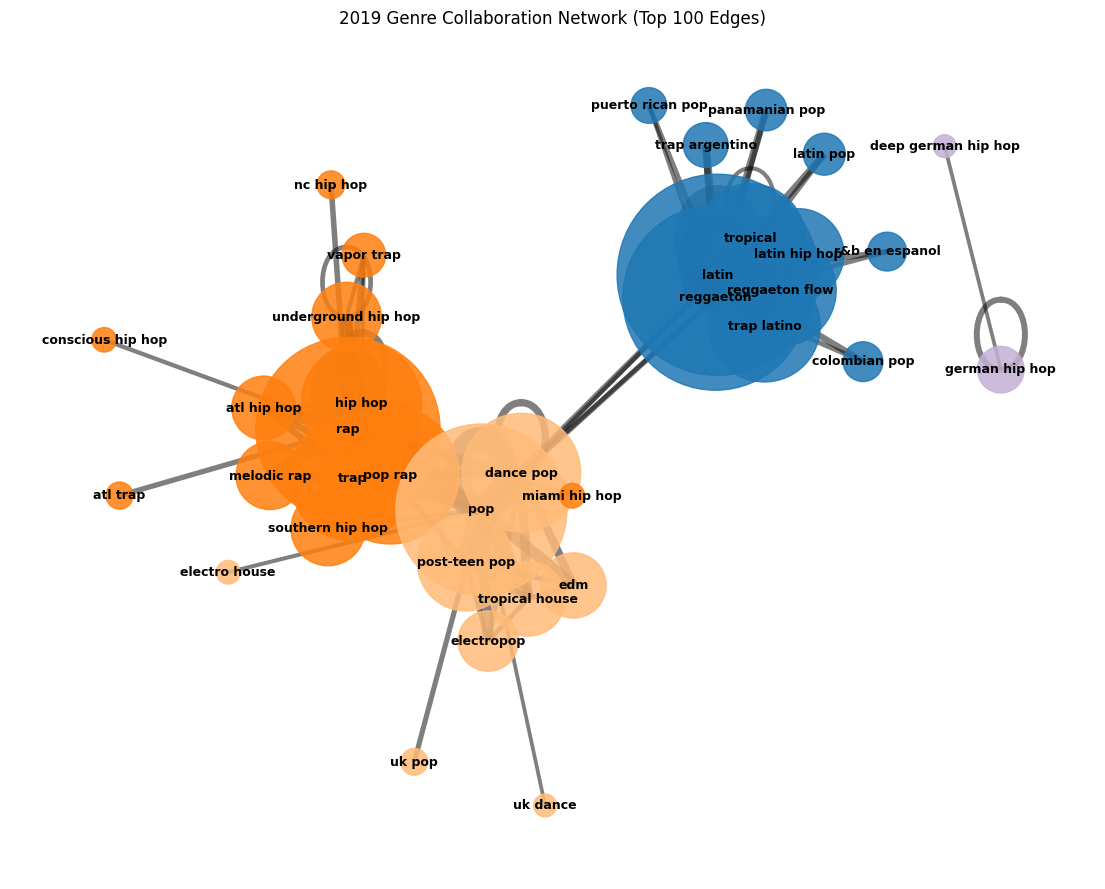


Hub/Bridge genres (top 10 by participation_coeff, betweenness):
               genre  community  degree_centrality  participation_coeff  \
80     reggae fusion          5           0.058252             0.743827   
89         dancehall          5           0.093851             0.717004   
10    reggaeton flow          0           0.187702             0.716706   
68           emo rap          2           0.113269             0.711020   
66        uk hip hop          5           0.071197             0.710744   
54   electronic trap          5           0.084142             0.710059   
0              latin          0           0.317152             0.708142   
4        trap latino          0           0.213592             0.705923   
214        glam rock          1           0.029126             0.703704   
3          reggaeton          0           0.300971             0.697769   

     betweenness  
80      0.000851  
89      0.009686  
10      0.027784  
68      0.003338  
66      0.0075

In [15]:
# genre network analysis and visualization for 2017-2019

files = {
    2017: '/content/global-artist_network-2017.csv',
    2018: '/content/global-artist_network-2018.csv',
    2019: '/content/global-artist_network-2019.csv'
}
artists_info = pd.read_csv('/content/spotify_artists_info_complete.csv', sep='\t', encoding='utf-8')
artists_info = artists_info.drop_duplicates(subset=['name'], keep='first')
artist_genre_map = artists_info.set_index('name')['genres'].to_dict()

def build_genre_network(network_file):
    df = pd.read_csv(network_file, sep=None, engine='python')
    if 'artist_1' not in df.columns:
        df.columns = [c.strip() for c in df.columns]
    edges = df[['artist_1', 'artist_2', 'count']].dropna()
    edges['count'] = pd.to_numeric(edges['count'], errors='coerce').fillna(1).astype(int)
    G = nx.Graph()
    for _, row in edges.iterrows():
        a1, a2, count = row['artist_1'], row['artist_2'], row['count']
        genres1 = artist_genre_map.get(a1, '')
        genres2 = artist_genre_map.get(a2, '')
        if isinstance(genres1, str):
            genres1 = [g.strip().strip("'[]") for g in genres1.split(',') if g.strip()]
        if isinstance(genres2, str):
            genres2 = [g.strip().strip("'[]") for g in genres2.split(',') if g.strip()]
        for g1 in genres1:
            for g2 in genres2:
                if not g1 or not g2:
                    continue
                edge = tuple(sorted([g1, g2]))
                if G.has_edge(*edge):
                    G[edge[0]][edge[1]]['weight'] += int(count)
                else:
                    G.add_edge(edge[0], edge[1], weight=int(count))
    return G

def analyze_and_visualize_genre_network(G, year):
    partition = community_louvain.best_partition(G, weight='weight')
    nx.set_node_attributes(G, partition, 'community')
    communities = set(partition.values())
    print(f"\n=== {year} Genre Network Analysis ===")
    # Community-wise top genres, entropy, crossover
    comm_to_genres = {}
    for node, comm in partition.items():
        comm_to_genres.setdefault(comm, []).append(node)
    for comm, genres in comm_to_genres.items():
        genre_counts = Counter(genres)
        total = sum(genre_counts.values())
        probs = np.array(list(genre_counts.values())) / total if total > 0 else np.array([1])
        entropy = -np.sum(probs * np.log2(probs))
        top_genres = genre_counts.most_common(5)
        print(f"Community {comm}: #genres={len(genres)}, entropy={entropy:.2f}, top genres={top_genres}")

    top_edges = sorted(G.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)[:100]
    subG = nx.Graph()
    for g1, g2, data in top_edges:
        subG.add_edge(g1, g2, weight=data['weight'])
    sub_partition = {n: partition[n] for n in subG.nodes()}
    cmap = plt.get_cmap('tab20')
    node_colors = [cmap(sub_partition[n] % 20) for n in subG.nodes()]
    node_sizes = [subG.degree(n, weight='weight')*10 for n in subG.nodes()]
    pos = nx.spring_layout(subG, k=1.2, seed=42)
    plt.figure(figsize=(14, 11))
    nx.draw_networkx_nodes(subG, pos, node_color=node_colors, node_size=node_sizes, alpha=0.85)
    nx.draw_networkx_edges(subG, pos, width=[subG[u][v]['weight']*0.1 for u, v in subG.edges()], alpha=0.5)
    nx.draw_networkx_labels(subG, pos, font_size=9, font_weight='bold')
    plt.title(f"{year} Genre Collaboration Network (Top 100 Edges)")
    plt.axis('off')
    plt.show()
    # Centrality and participation coefficient
    deg = nx.degree_centrality(G)
    btw = nx.betweenness_centrality(G, weight='weight')
    def participation_coefficient(G, partition):
        pc = {}
        for node in G.nodes():
            comm = partition[node]
            deg_node = G.degree(node)
            if deg_node == 0:
                pc[node] = 0
                continue
            comm_deg = Counter()
            for nbr in G.neighbors(node):
                nbr_comm = partition[nbr]
                comm_deg[nbr_comm] += 1
            sum_sq = sum((count/deg_node)**2 for count in comm_deg.values())
            pc[node] = 1 - sum_sq
        return pc
    pc = participation_coefficient(G, partition)
    # Hub/bridge genres
    bridge_df = pd.DataFrame({
        'genre': list(G.nodes()),
        'community': [partition[n] for n in G.nodes()],
        'degree_centrality': [deg[n] for n in G.nodes()],
        'participation_coeff': [pc[n] for n in G.nodes()],
        'betweenness': [btw[n] for n in G.nodes()]
    })
    print("\nHub/Bridge genres (top 10 by participation_coeff, betweenness):")
    bridges = bridge_df.sort_values(['participation_coeff', 'betweenness'], ascending=False).head(10)
    print(bridges[['genre', 'community', 'degree_centrality', 'participation_coeff', 'betweenness']])

for year, path in files.items():
    Gg = build_genre_network(path)
    analyze_and_visualize_genre_network(Gg, year)


## Emerging Genre Community Detection + Central Artists


In this section, we will look into emerging genre communities and the central artists for them.

In [21]:

files = {
    2017: 'global-artist_network-2017.csv',
    2018: 'global-artist_network-2018.csv',
    2019: 'global-artist_network-2019.csv'
}

artists_info = pd.read_csv('spotify_artists_info_complete.csv', sep='\t', encoding='utf-8')
artists_info = artists_info.drop_duplicates(subset=['name'], keep='first')
artist_genre_map = artists_info.set_index('name')['genres'].to_dict()

community_degree_time = {}
for year, path in files.items():
    df = pd.read_csv(path, sep='\t', engine='python', quoting=3)
    df.columns = df.columns.str.strip()
    edges = df[['artist_1', 'artist_2', 'count']].dropna()
    edges['count'] = pd.to_numeric(edges['count'], errors='coerce').fillna(1).astype(int)
    G = nx.Graph()
    for _, row in edges.iterrows():
        G.add_edge(row['artist_1'], row['artist_2'], weight=row['count'])
    partition = community_louvain.best_partition(G, weight='weight')
    degrees = dict(G.degree(weight='weight'))
    comm_degree = {}
    for comm in set(partition.values()):
        nodes = [n for n, c in partition.items() if c == comm]
        deg_sum = sum(dict(G.degree(nodes, weight='weight')).values())
        comm_degree[comm] = deg_sum
    community_degree_time[year] = comm_degree

all_communities = set()
for comms in community_degree_time.values():
    all_communities.update(comms.keys())
all_communities = list(all_communities)

degree_data = {}
for year in files.keys():
    degree_data[year] = [community_degree_time[year].get(comm, 0) for comm in all_communities]
degree_df = pd.DataFrame(degree_data, index=all_communities)

degree_df['diff_18_17'] = degree_df[2018] - degree_df[2017]
degree_df['diff_19_18'] = degree_df[2019] - degree_df[2018]

# relaxed condition: 2017 degree ≤ 100, and (2018-2017 > 200) or (2019-2018 > 200)
emerging = degree_df[(degree_df[2017] <= 100) & ((degree_df['diff_18_17'] > 200) | (degree_df['diff_19_18'] > 200))]
emerging = emerging.sort_values(['diff_18_17', 'diff_19_18'], ascending=False)

print("Emerging genre communities:")
print(emerging[[2017, 2018, 2019, 'diff_18_17', 'diff_19_18']])

def get_community_detail(year, comm):
    df = pd.read_csv(files[year], sep='\t', engine='python', quoting=3)
    df.columns = df.columns.str.strip()
    edges = df[['artist_1', 'artist_2', 'count']].dropna()
    edges['count'] = pd.to_numeric(edges['count'], errors='coerce').fillna(1).astype(int)
    G = nx.Graph()
    for _, row in edges.iterrows():
        G.add_edge(row['artist_1'], row['artist_2'], weight=row['count'])
    partition = community_louvain.best_partition(G, weight='weight')
    degrees = dict(G.degree(weight='weight'))
    comm_nodes = [n for n, c in partition.items() if c == comm]
    genres = []
    for n in comm_nodes:
        g = artist_genre_map.get(n)
        if isinstance(g, str):
            genres.extend([x.strip() for x in g.replace("'", "").replace("[", "").replace("]", "").replace('"', '').split(',') if x.strip()])
    genre_counts = Counter(genres)
    top_genres = genre_counts.most_common(5)
    if comm_nodes:
        rep_artist = max(comm_nodes, key=lambda n: degrees.get(n, 0))
    else:
        rep_artist = None
    return top_genres, rep_artist

print("\nEmerging communities (2019) - Top genres and central artist:")
for comm in emerging.index:
    top_genres, rep_artist = get_community_detail(2019, comm)
    print(f"- Community {comm}:")
    print(f"  Top 5 genres: {top_genres}")
    print(f"  Central artist: {rep_artist}")
    if rep_artist:
        genres = artist_genre_map.get(rep_artist, '')
        print(f"    (Genres: {genres})")


Emerging genre communities:
    2017  2018  2019  diff_18_17  diff_19_18
1      2   326     6         324        -320
10     2    54   709          52         655
5     70     2   534         -68         532

Emerging communities (2019) - Top genres and central artist:
- Community 1:
  Top 5 genres: [('latin', 31), ('reggaeton', 27), ('reggaeton flow', 16), ('tropical', 16), ('latin hip hop', 12)]
  Central artist: J Balvin
    (Genres: ['latin', 'reggaeton'])
- Community 10:
  Top 5 genres: [('pop', 18), ('dance pop', 13), ('post-teen pop', 10), ('tropical house', 9), ('edm', 7)]
  Central artist: The Chainsmokers
    (Genres: ['electropop', 'pop', 'tropical house'])
- Community 5:
  Top 5 genres: [('italian hip hop', 2)]
  Central artist: Gemitaiz
    (Genres: ['italian hip hop'])


## Discussion

### What went well: Effective network construction

Weighted edges captured the collaboration strength, which reveals genre relationship. It also highlighted dominant genre fusions (eg pop-pop rap) over rarer pairings.

### What could be improved: Missing directionality

The graph we have plotted is undirected, a directed graph would have been able to show us whether pop artists collaborated with rap artists more, or vice versa. 

### What could be improved: Over-fragmentation

The network we have worked on treats 'gangster rap', 'melodic rap', 'pop rap', 'rap' as separate genres which inflates the number of nodes, making the graph noisy. It also misses the bigger picture such as rap's overall influence on pop by splitting collaborations that could have been 'rap'+'pop' instead of 'pop rap'+'pop'.